<center><h1>Методы Монте-Карло и машинное обучение</h1></center>

In [1]:
!python -V # Версия Python

Python 3.12.8


In [2]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

### Импорт необходимых библиотек
import os
import numpy as np
import torch
import polars as pl
import pandas as pd
import sklearn
import scipy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import jupyterlab as jlab
import ipywidgets
import random

from scipy.integrate import quad
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
### Версии необходимых библиотек
packages = [
    "Torch", "NumPy", "Polars", "Pandas", "Seaborn", "Matplotlib", "Scipy", "Scikit-learn", "Ipywidgets", "JupyterLab"
]

package_objects = [
    torch, np, pl, pd, sns, mpl, scipy, sklearn, ipywidgets, jlab
]

versions = list(map(lambda obj: obj.__version__, package_objects))

columns_order = ["№", "Библиотека", "Версия"]
df_pkgs = (
    pl.DataFrame({
        columns_order[1]: packages,
        columns_order[2]: versions
    })
    .with_columns(pl.arange(1, pl.lit(len(packages)) + 1).alias(columns_order[0]))
    .select(columns_order)
)

display(df_pkgs)

path2reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""
    
    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path2reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

№,Библиотека,Версия
i64,str,str
1,"""Torch""","""2.2.2"""
2,"""NumPy""","""1.26.4"""
3,"""Polars""","""1.19.0"""
4,"""Pandas""","""2.2.3"""
5,"""Seaborn""","""0.13.2"""
6,"""Matplotlib""","""3.10.0"""
7,"""Scipy""","""1.15.1"""
8,"""Scikit-learn""","""1.6.1"""
9,"""Ipywidgets""","""8.1.5"""


# Лекция 3

4. **Марковские цепи Монте-Карло.**
   - Алгоритмы Метрополис-Хастингса и Гиббса, их применение в байесовской оптимизации и апостериорном анализе.
   - Примеры использования Марковских цепей Монте-Карло для генерации выборок из сложных распределений и моделирования неопределенности.

## Марковские цепи Монте-Карло (МЦМК)

Методы на основе МЦМК позволяют генерировать выборки из сложных распределений, из которых сложно взять выборки напрямую. Таким образом МЦМК можно использовать, когда нужно проводить:

1. **Байесовский анализ**, который помогает узнать, насколько вероятен тот или иной результат, если уже есть данные об этом

**Пример**: ученые хотят понять, как температура влияет на рост растений. У них есть два источника информации:

- *Априорное распределение* - их предположения о том, как температура влияет на рост, до проведения экспериментов (скорее всего, растения растут быстрее при 20-25°C)
- *Новые данные* - результаты экспериментов, например, сколько растение выросло при разных температурах

**Как это работает?** Байесовский анализ объединяет старые знания (*априорное распределение*), новые данные (*результаты экспериментов*) и выдает обновленные знания (*апостериорное распределение*). Оно показывает, что теперь можно думать о том, как температура влияет на рост растений

$$
P(\text{параметр | данные}) = \frac{P(\text{данные | параметр}) \times P(\text{параметр})}{P(\text{данные})}
$$

где:
- $P(\text{параметр | данные})$: новая вероятность (*апостериорное распределение*)
- $P(\text{данные | параметр})$: вероятность увидеть нужные данные при заданных параметрах
- $P(\text{параметр})$: старая вероятность (*априорное распределение*)
- $P(\text{данные})$: общая вероятность данных

**Проблема.** Часто вычислить *апостериорное распределение* аналитически (точно) невозможно, потому что формулы становятся очень сложными

**Как помогают МЦМК?** Методы  создают последовательность случайных чисел (выборок), которые приближают распределение. С их помощью мы можем не вычислять сложные интегралы, а просто `построить` распределение выборками. Это как будто ученые указывают много `кандидатов` для параметра и проверяют их

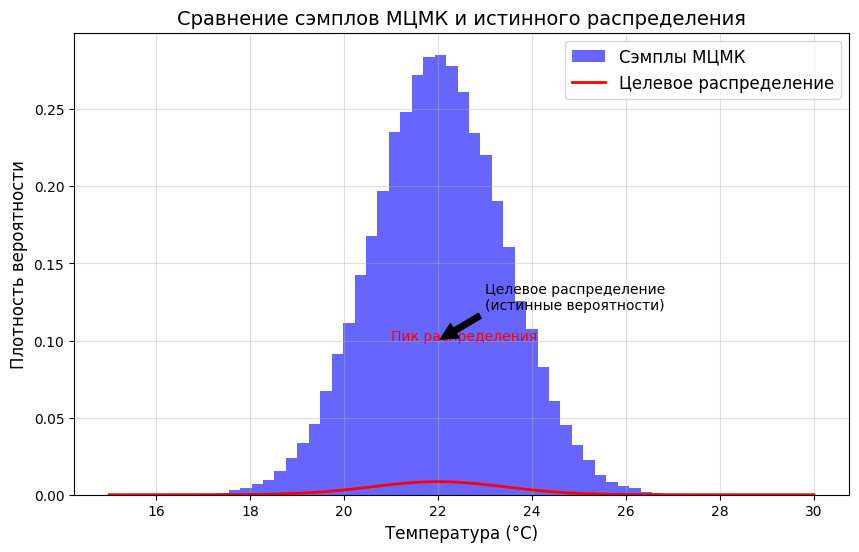

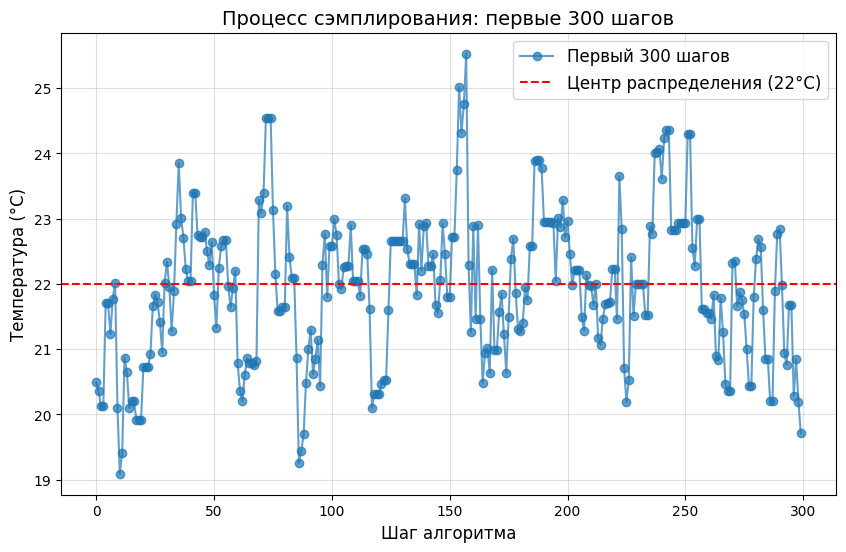

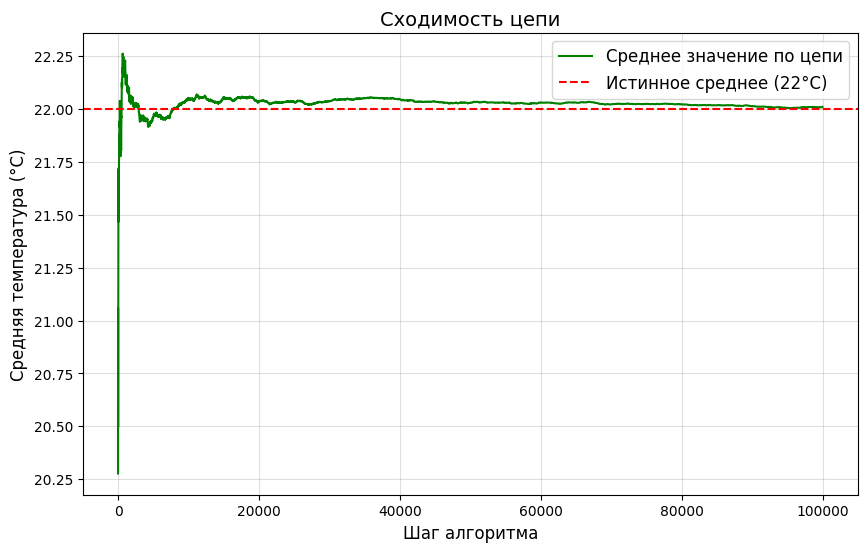

Средняя температура (центральная тенденция): 22.01 °C
Медианная температура: 22.00 °C
Мода температуры (пик распределения): 21.42 °C


In [4]:
np.random.seed(42)

# Целевое распределение: вероятности параметра (рост растений при температуре)
def target_distribution(temp):
    # Гипотеза: рост растений наилучший около 22°C, но падает по краям
    return np.exp(-((temp - 22)**2) / 4)

def metropolis_hastings(target, steps, start = 20, proposal_width = 1):
    samples = []
    current = start
    
    for _ in range(steps):
        proposed = current + np.random.normal(0, proposal_width) # Предложение точки
        acceptance_ratio = target(proposed) / target(current) # Отношение вероятностей
        
        if np.random.rand() < acceptance_ratio: # Точка принимается с вероятностью
            current = proposed
        
        samples.append(current)
    
    return np.array(samples)

# Генерация выборки
samples = metropolis_hastings(target_distribution, steps = 100000)

# Визуализация целевого распределения
temp_range = np.linspace(15, 30, 500)
true_distribution = target_distribution(temp_range)
true_distribution_normalized = true_distribution / np.sum(true_distribution)

# Построение гистограммы сэмплов
plt.figure(figsize = (10, 6))
plt.hist(samples, bins = 50, density = True, alpha = 0.6, label = "Сэмплы МЦМК", color = "blue")
plt.plot(temp_range, true_distribution_normalized, label = "Целевое распределение", color = "red", lw = 2)

# Аннотации
plt.text(21, 0.1, "Пик распределения", fontsize = 10, color = "red")
plt.annotate(
    "Целевое распределение\n(истинные вероятности)", 
    xy = (22, 0.1), xytext = (23, 0.12),
    arrowprops = dict(facecolor = "black", shrink = 0.05)
)

# Оформление
plt.title("Сравнение сэмплов МЦМК и истинного распределения", fontsize = 14)
plt.xlabel("Температура (°C)", fontsize = 12)
plt.ylabel("Плотность вероятности", fontsize = 12)
plt.legend(fontsize = 12)
plt.grid(alpha = 0.4)
plt.show()

# Визуализация процесса сэмплирования
plt.figure(figsize = (10, 6))
plt.plot(samples[:300], marker = "o", label = "Первый 300 шагов", alpha = 0.7)
plt.axhline(22, color = "red", linestyle = "--", label = "Центр распределения (22°C)")
plt.title("Процесс сэмплирования: первые 300 шагов", fontsize = 14)
plt.xlabel("Шаг алгоритма", fontsize = 12)
plt.ylabel("Температура (°C)", fontsize = 12)
plt.legend(fontsize = 12)
plt.grid(alpha = 0.4)
plt.show()

# Анализ сходимости
plt.figure(figsize = (10, 6))
plt.plot(np.cumsum(samples) / np.arange(1, len(samples) + 1), label = "Среднее значение по цепи", color = "green")
plt.axhline(22, color = "red", linestyle = "--", label = "Истинное среднее (22°C)")
plt.title("Сходимость цепи", fontsize = 14)
plt.xlabel("Шаг алгоритма", fontsize = 12)
plt.ylabel("Средняя температура (°C)", fontsize = 12)
plt.legend(fontsize = 12)
plt.grid(alpha = 0.4)
plt.show()

mean_temp = np.mean(samples) # Среднее значение
median_temp = np.median(samples) # Медиана
mode_temp = samples[np.argmax(np.histogram(samples, bins = 50, density = True)[0])] # Оценка моды

print(f"Средняя температура (центральная тенденция): {mean_temp:.2f} °C")
print(f"Медианная температура: {median_temp:.2f} °C")
print(f"Мода температуры (пик распределения): {mode_temp:.2f} °C")

**Что показывает график?**

- *Красная линия* - предположения о росте растений (вероятность в зависимости от температуры)
- *Гистограмма* - результат работы МЦМК (выборки параметров, которые `наиболее вероятны` при учете данных

2. **Интеграция сложных функций**, которая необходима, когда нужно вычислить площадь под кривой или общую вероятность на каком-то интервале. Например, при анализе природных явлений, таких как вероятность дождя в течение дня.

**Пример**: есть функция, которая описывает вероятность дождя в зависимости от времени суток:

$$
P(t) = \sin\left(\frac{\pi t}{24}\right) \times \exp\left(-\frac{(t - 12)^2}{50}\right)
$$

где: $t$ - время суток (от 0 до 24 часов). Эта функция показывает, что дождь более вероятен в середине дня (около 12:00)

**Цель**: найти *общую вероятность дождя в течение дня*, то есть вычислить интеграл:

$$
I = \int_0^{24} P(t) \, dt
$$

**Уточнения:**

Почему делится на 50 в формуле:

$$
\exp\left(-\frac{(t - 12)^2}{50}\right)
$$

чтобы контролировать ширину `колокола` функции вероятности. Это коэффициент масштаба, который влияет на то, насколько `резко` изменяется вероятность дождя в зависимости от времени суток

*Общий вид функции:*

$$
\exp\left(-\frac{(t - \mu)^2}{\sigma^2}\right)
$$

гауссианоподобная функция, где:

- $\mu$ (среднее) - центр распределения, в данном примере случае 12 (середина дня)
- $\sigma^2$ - дисперсия, которая определяет ширину распределения

Деление на 50 (или, эквивалентно, $\sigma^2 = 50$) делает распределение `плоским`. Чем больше значение в знаменателе, тем шире и менее крутой график

Приближенное значение интеграла (Монте-Карло): 10.24657
Истинное значение интеграла (Scipy): 10.15975


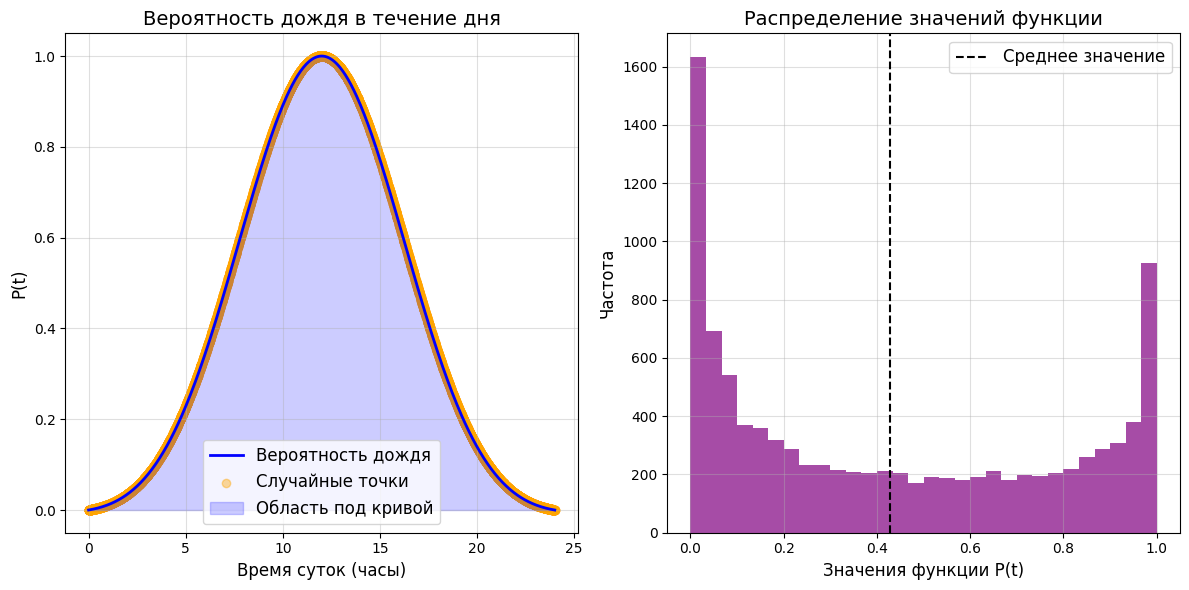

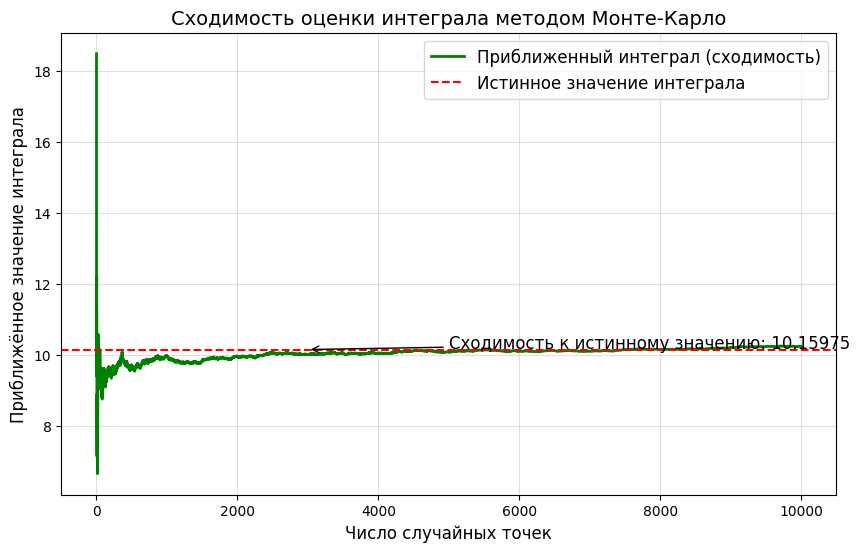

In [5]:
# Функция вероятности дождя
def rain_probability(t):
    return np.sin(np.pi * t / 24) * np.exp(-((t - 12)**2) / 50)

# Метод Монте-Карло для интеграции
def monte_carlo_integration(func, a, b, num_samples, seed = 42):
    np.random.seed(seed)
    samples = np.random.uniform(a, b, num_samples) # Генерация случайных точек
    function_values = func(samples) # Вычисление значений функции в этих точках
    integral = (b - a) * np.mean(function_values) # Приближенное значение интеграла
    return integral, samples, function_values

# Параметры задачи
a, b = 0, 24 # Интервал времени (сутки)
num_samples = 10000 # Количество случайных точек

# Вычисление интеграла методом Монте-Карло
integral_mc, samples, function_values = monte_carlo_integration(rain_probability, a, b, num_samples)

# Вычисление истинного значения интеграла для сравнения
true_integral, _ = quad(rain_probability, a, b)

# Результаты
print(f"Приближенное значение интеграла (Монте-Карло): {integral_mc:.5f}")
print(f"Истинное значение интеграла (Scipy): {true_integral:.5f}")

# Построение графика функции вероятности дождя
t = np.linspace(a, b, 500)
rain_prob = rain_probability(t)

plt.figure(figsize = (12, 6))

# График функции вероятности дождя
plt.subplot(1, 2, 1)
plt.plot(t, rain_prob, label = "Вероятность дождя", color = "blue", lw = 2)
plt.scatter(samples, function_values, color = "orange", alpha = 0.4, label = "Случайные точки")
plt.fill_between(t, 0, rain_prob, color = "blue", alpha = 0.2, label = "Область под кривой")
plt.title("Вероятность дождя в течение дня", fontsize = 14)
plt.xlabel("Время суток (часы)", fontsize = 12)
plt.ylabel("P(t)", fontsize = 12)
plt.legend(fontsize = 12)
plt.grid(alpha = 0.4)

# Гистограмма распределения значений функции
plt.subplot(1, 2, 2)
plt.hist(function_values, bins = 30, color = "purple", alpha = 0.7)
plt.axvline(np.mean(function_values), color = "black", linestyle = "dashed", label = "Среднее значение")
plt.title("Распределение значений функции", fontsize = 14)
plt.xlabel("Значения функции P(t)", fontsize = 12)
plt.ylabel("Частота", fontsize = 12)
plt.legend(fontsize = 12)
plt.grid(alpha = 0.4)

plt.tight_layout()
plt.show()

# Анализ сходимости метода Монте-Карло
cumulative_integral = np.cumsum(function_values) / np.arange(1, num_samples + 1) * (b - a)

plt.figure(figsize = (10, 6))
plt.plot(cumulative_integral, label = "Приближенный интеграл (сходимость)", color = "green", lw = 2)
plt.axhline(true_integral, color = "red", linestyle = "--", label = "Истинное значение интеграла")
plt.title("Сходимость оценки интеграла методом Монте-Карло", fontsize = 14)
plt.xlabel("Число случайных точек", fontsize = 12)
plt.ylabel("Приближённое значение интеграла", fontsize = 12)
plt.legend(fontsize = 12)
plt.grid(alpha = 0.4)

# Добавление аннотаций для сходимости
plt.annotate(
    f"Сходимость к истинному значению: {true_integral:.5f}", xy = (3000, true_integral), 
    xytext = (5000, true_integral + 0.02), arrowprops = dict(facecolor = "black", arrowstyle = "->"),
    fontsize = 12
)

plt.show()

3. **Оптимизация функций с неопределенным видом** - задача, когда форма функции или ее аналитическое представление не всегда может быть точно определено, или когда функция имеет несколько экстремумов, скачки или неопределенности. Это часто встречается в реальных приложениях, где функции могут быть заданы неявно, через симуляции или эмпирические данные, и могут включать случайные компоненты или шум

**Математическое представление:** оптимизировать функцию $f(x)$, которая может быть сложной и содержать неопределенности. Задача оптимизации заключается в нахождении точки $x^*$, которая минимизирует (или максимизирует) функцию:

$$
x^* = \arg\min_{x} f(x)
$$

где $f(x)$ - функция, для которой не известно точное аналитическое представление или она содержит шум

**Методы оптимизации**, которые позволяют находить минимум или максимум без знания точной формы функции. Одним из самых популярных методов является *градиентный спуск*

**Градиентный спуск** использует информацию о производной функции (градиенте) для поиска точки минимума. Простейшее описание метода следующее:

- Старт с произвольной точки $x_0$
- В каждой итерации вычисляется градиент функции $\nabla f(x)$, который показывает, в каком направлении функция увеличивается быстрее всего
- Движение в противоположном направлении (в сторону уменьшения функции) на шаг, пропорциональный этому градиенту

Обновление точки происходит по следующей формуле:

$$
x_{n+1} = x_n - \eta \nabla f(x_n)
$$

где:
- $x_n$ - текущая точка
- $\eta$ - скорость обучения (learning rate)
- $\nabla f(x_n)$ - градиент функции в точке $x_n$

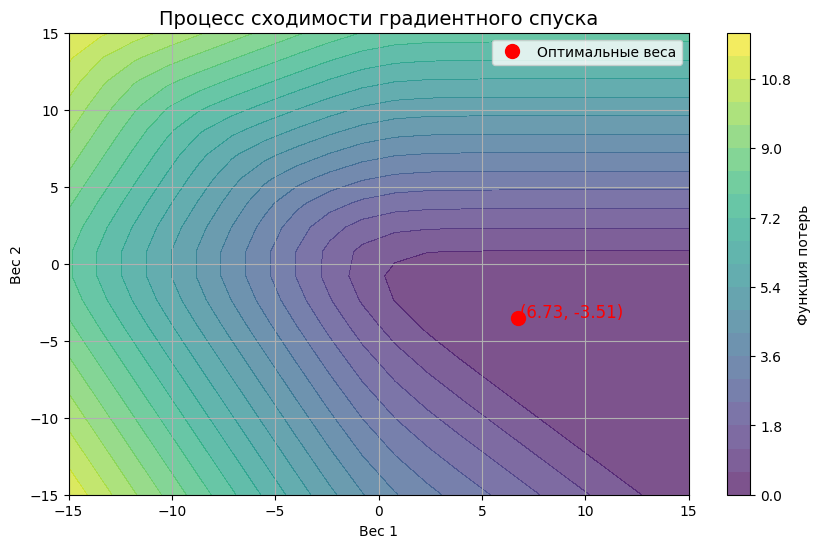

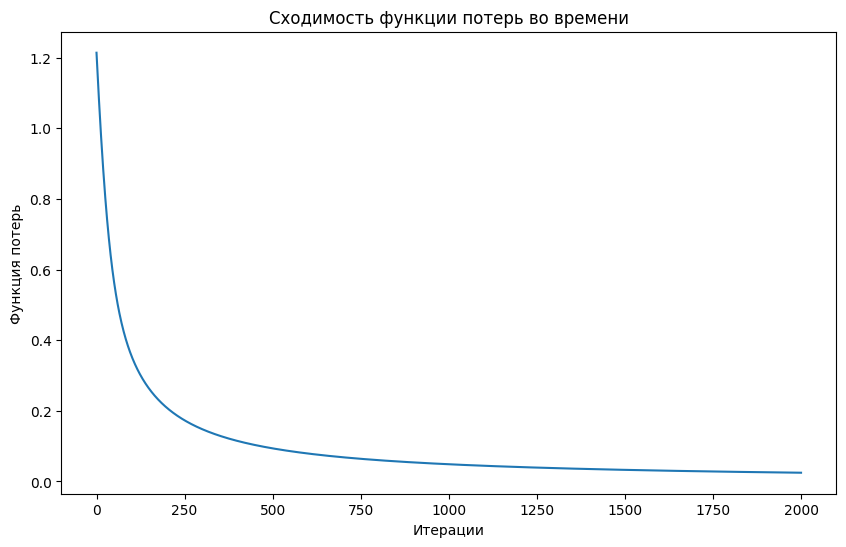

In [6]:
# Пример текстов
texts = [
    "Программирование на Python и машинное обучение",
    "Машинное обучение на Python для анализа данных",
    "Программирование на Java",
    "Мобильная разработка на Java",
    "Мобильная разработка на Python",
    "Наука о данных и Python"
]

# Метки для классификации (1 - Python, 0 - Java)
labels = np.array([1, 1, 0, 0, 1, 1])

# Векторизация текстов в числовые признаки
vectorizer = CountVectorizer(max_features = 2)
X = vectorizer.fit_transform(texts).toarray()

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2, random_state = 42)

# Функция потерь для логистической регрессии
def loss_function(w, X, y):
    predictions = 1 / (1 + np.exp(-np.dot(X, w))) # Логистическая функция активации
    error = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)
    return np.mean(error)

# Градиент функции потерь
def gradient_loss(w, X, y):
    predictions = 1 / (1 + np.exp(-np.dot(X, w))) # Логистическая функция активации
    return np.dot(X.T, predictions - y) / len(y) # Градиент логистической регрессии

# Градиентный спуск
def gradient_descent(X, y, learning_rate = 0.1, num_iterations = 2000):
    w = np.random.randn(X.shape[1]) # Инициализация весов случайными значениями
    losses = [] # Список для хранения значений потерь на каждой итерации
    for i in range(num_iterations):
        grad = gradient_loss(w, X, y) # Вычисление градиента
        w -= learning_rate * grad # Обновление весов
        losses.append(loss_function(w, X, y)) # Добавление текущего значения потерь
    return w, losses

# Обучение модели с помощью градиентного спуска
optimal_weights, losses = gradient_descent(X_train, y_train, learning_rate = 0.1, num_iterations = 2000)

# Визуализация процесса сходимости
plt.figure(figsize = (10, 6))

# Сетка для двух признаков
w1_vals = np.linspace(-15, 15, 20)
w2_vals = np.linspace(-15, 15, 20)
W1, W2 = np.meshgrid(w1_vals, w2_vals)

# Вычисление функции потерь для каждой комбинации весов
Z = np.array([loss_function(np.array([w1, w2]), X_train, y_train) for w1, w2 in zip(W1.flatten(), W2.flatten())])
Z = Z.reshape(W1.shape)

plt.contourf(W1, W2, Z, levels = 20, cmap = "viridis", alpha = 0.7)

plt.plot(optimal_weights[0], optimal_weights[1], "ro", markersize = 10, label = "Оптимальные веса")

plt.text(optimal_weights[0] + 0.1, optimal_weights[1], f'({optimal_weights[0]:.2f}, {optimal_weights[1]:.2f})', color = "red", fontsize = 12)

plt.title("Процесс сходимости градиентного спуска", fontsize = 14)
plt.xlabel("Вес 1")
plt.ylabel("Вес 2")
plt.colorbar(label = "Функция потерь")
plt.legend()
plt.grid(True)

plt.figure(figsize = (10, 6))
plt.plot(losses)
plt.xlabel("Итерации")
plt.ylabel("Функция потерь")
plt.title("Сходимость функции потерь во времени")
plt.show()

## Алгоритмы Метрополис-Хастингса и Гиббса, их применение в байесовской оптимизации и апостериорном анализе

### Алгоритм Метрополиса-Хастингса

Способ случайного подбора значений из сложного распределения.

**Пример**: Необходимо сгенерировать выборку, чтобы смоделировать распределение вероятностей класса в задаче классификации. Не известна точная форма распределения, но необходимо получить примеры, которые соответствуют апостериорной вероятности класса на основе данных. Вместо того чтобы использовать готовую формулу, эти числа генерируются шаг за шагом с помощью случайных `прыжков`

**Как работает алгоритм?**

1. **Начальная точка.** Выбирается стартовая точка $x_0$, например, $x_0 = 0$
2. **Шаг предложения.** Производится `переход` из текущей точки $x_t$ в новую точку $x'$. Этот шаг берется случайно, например, из нормального распределения.
3. **Решается, принять или отклонить точку**, через вычисление вероятности того, что новая точка лучше текущей

$$
r = \frac{\pi(x')}{\pi(x_t)}
$$

- Если $r \geq 1$, то новая точка принимается
- Если $r < 1$, то принимается новая точка с вероятностью $r$. Если не принимается, остается $x_t$
4. **Повторение** шагов, пока не получится достаточно значений

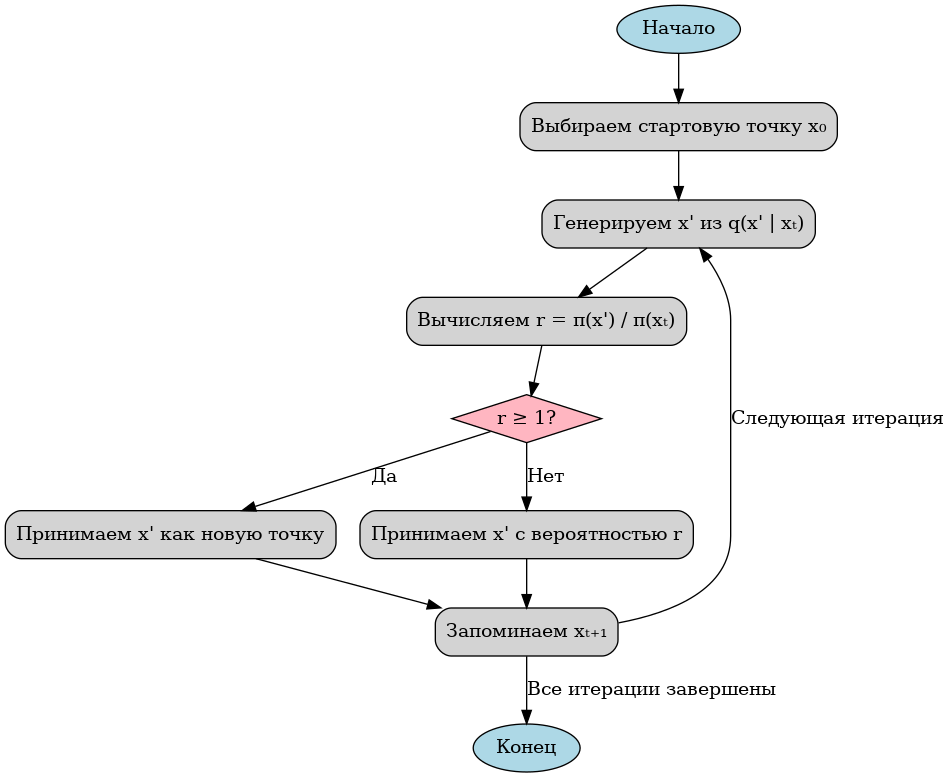

#### Задача: предсказать вероятности классов в задаче распознавания эмоций

**Постановка задачи**. Представим, что мы обучаем модель для распознавания эмоций в тексте. У нас есть 7 классов эмоций (радость, грусть, страх, гнев, удивление, отвращение, нейтральное состояние). Мы хотим сгенерировать выборку параметров модели, чтобы *апостериорное распределение* параметров лучше описывало вероятность принадлежности текста к определенному классу

**Целевое распределение.** Необходимо апостериорное распределение параметров $\pi(\theta)$, которое пропорционально:

$$
\pi(\theta) \propto P(\text{данные} \mid \theta) \times P(\theta)
$$

где:
- $P(\text{данные} \mid \theta)$ - правдоподобие данных при параметрах $\theta$
- $P(\theta)$ - априорное распределение параметров

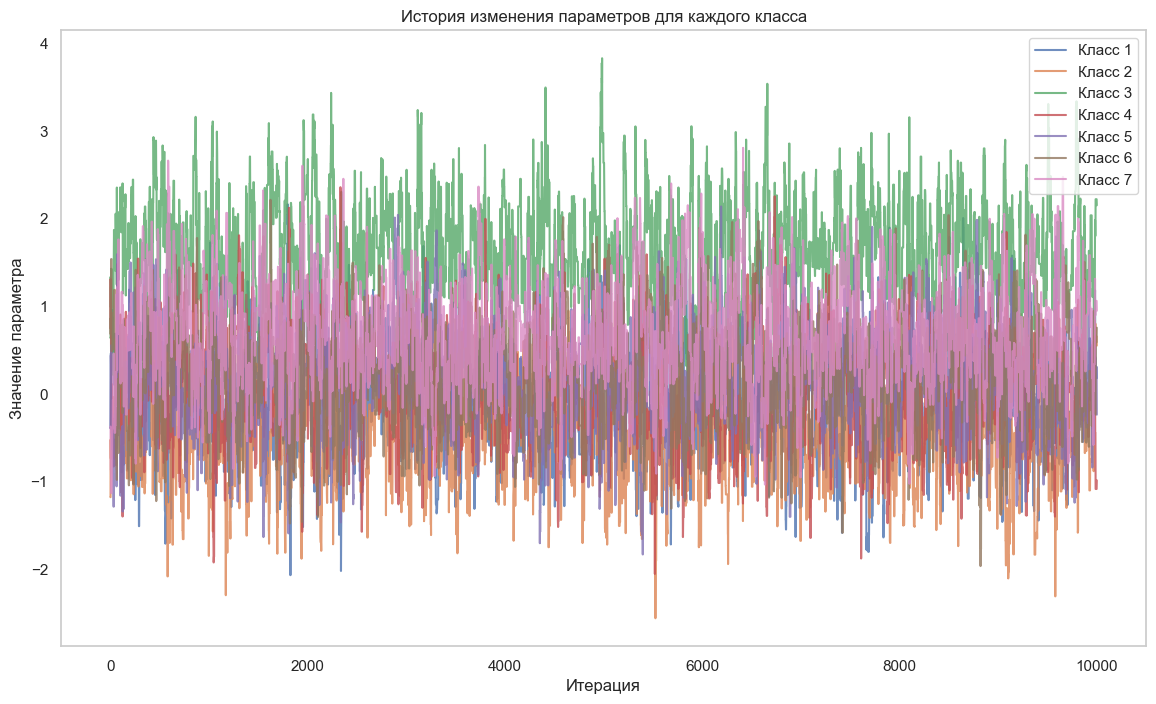

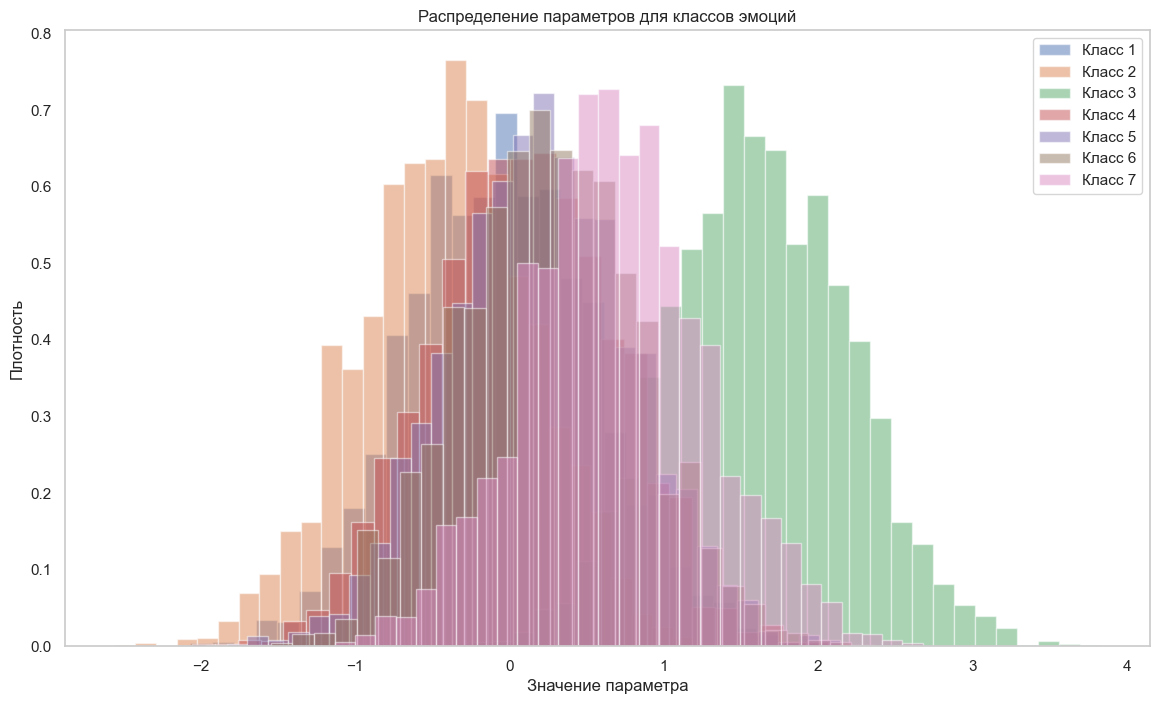

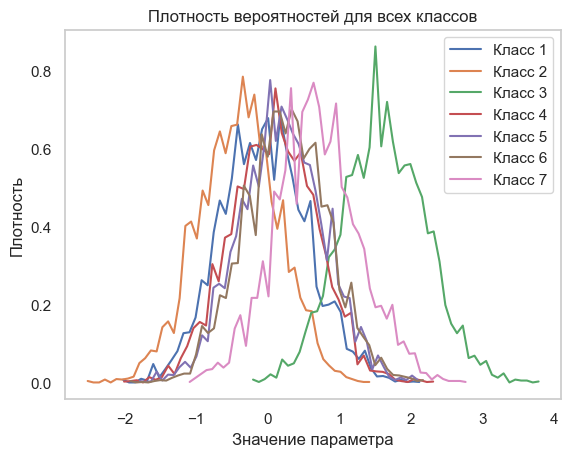

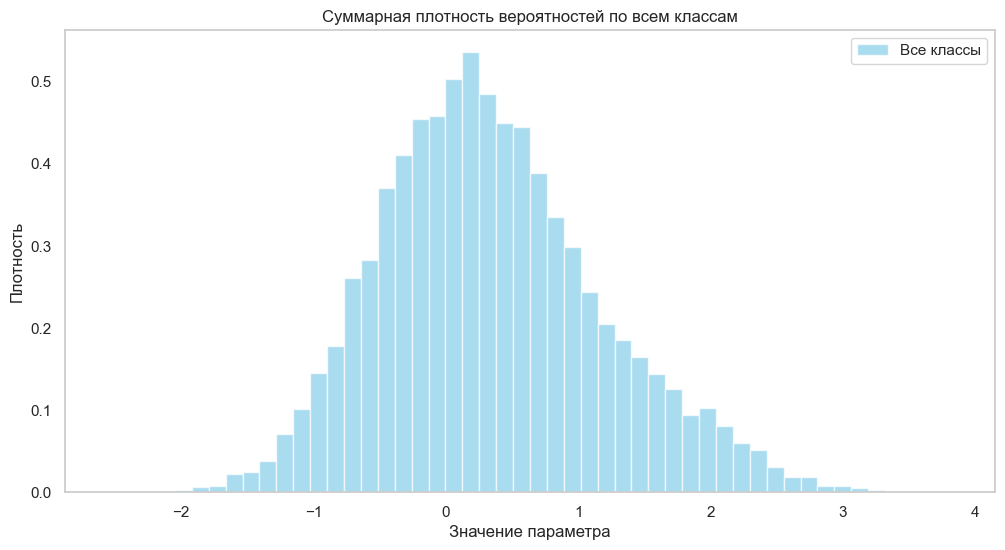

In [20]:
# Эмуляция данных: правдоподобие и априорное распределение
def likelihood(data, theta):
    return np.exp(-np.sum((data - theta) ** 2)) # Правдоподобие (например, на основе гауссовой функции)

def prior(theta):
    return np.exp(-np.sum(theta ** 2) / 2) # Априорное распределение (нормальное)

def target_distribution(theta, data):
    return likelihood(data, theta) * prior(theta)

# Алгоритм Метрополиса-Хастингса
def metropolis_hastings(data, n_samples, proposal_std = 0.5):
    samples = []
    theta = np.random.normal(0, 1, size = data.shape) # Начальная точка

    for _ in range(n_samples):
        theta_new = theta + np.random.normal(0, proposal_std, size = data.shape) # Предложение
        r = target_distribution(theta_new, data) / target_distribution(theta, data)
        if np.random.rand() < r:
            theta = theta_new
        samples.append(theta)
    
    return np.array(samples)

# Данные и запуск алгоритма
data = np.random.normal(0, 1, size = (7,)) # Эмуляция данных для 7 классов
samples = metropolis_hastings(data, n_samples = 10000)

# Визуализация истории параметров для каждого класса
plt.figure(figsize = (14, 8))
for i in range(data.shape[0]):
    plt.plot(samples[:, i], label = f"Класс {i+1}", alpha = 0.8)
plt.title("История изменения параметров для каждого класса")
plt.xlabel("Итерация")
plt.ylabel("Значение параметра")
plt.legend()
plt.grid()
plt.show()

# Распределение параметров для всех классов
plt.figure(figsize = (14, 8))
for i in range(data.shape[0]):
    plt.hist(samples[:, i], bins = 30, alpha = 0.5, label = f"Класс {i+1}", density = True)
plt.title("Распределение параметров для классов эмоций")
plt.xlabel("Значение параметра")
plt.ylabel("Плотность")
plt.legend()
plt.grid()
plt.show()

# Сравнение плотностей для всех классов
x = np.linspace(-3, 3, 500)
for i in range(data.shape[0]):
    density, bins = np.histogram(samples[:, i], bins = 50, density = True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    plt.plot(bin_centers, density, label = f"Класс {i+1}")
plt.title("Плотность вероятностей для всех классов")
plt.xlabel("Значение параметра")
plt.ylabel("Плотность")
plt.legend()
plt.grid()
plt.show()

# Обобщённая плотность вероятностей
all_samples = samples.flatten()
plt.figure(figsize = (12, 6))
plt.hist(all_samples, bins = 50, density = True, alpha = 0.7, color = "skyblue", label = "Все классы")
plt.title("Суммарная плотность вероятностей по всем классам")
plt.xlabel("Значение параметра")
plt.ylabel("Плотность")
plt.legend()
plt.grid()
plt.show()

#### Задача: предсказать вероятности классов в задаче распознавания жестов

**Постановка задачи**. Представим, что мы обучаем модель для распознавания жестов рук. У нас есть два жеста, которые нужно различить:
1. **"ОК"** - когда большой палец и указательный палец соединяются в круг
2. **"Не ОК"** - когда жест отличается от `ОК` (например, кулак)

Цель заключается в том, чтобы модель могла понять, какой из этих жестов был сделан, на основе данных, которые мы ей подаем (например, фотографии или видео). Для этого нужно сгенерировать параметры модели, которая будет описывать, как выглядит каждый жест. Эти параметры покажут, какие особенности жестов (например, угол между пальцами или их положение) наиболее важны для классификации

Мы хотим, чтобы наша модель могла предсказать, какой жест был сделан, с высокой вероятностью. Но сначала, чтобы лучше понять, как эти жесты могут быть представлены в данных, мы сгенерируем параметры, которые могут быть полезны для этой задачи

**Что такое `сгенерировать параметры модели`?**

На данном этапе мы **не обучаем модель** (то есть не настраиваем ее с помощью примеров), а **генерируем возможные значения параметров**, которые могут быть использованы для различения жестов. Это как если бы мы рисовали карты, показывающие, где могут находиться жесты `ОК` и `Не ОК`, основываясь на наших предположениях и некоторой логике

**Как это применяется?**
1. **Правдоподобие**: Мы предполагаем, что жест `ОК` будет иметь определенные параметры (например, угол между пальцами, который примерно равен 90 градусам), а жест `Не ОК` — другие параметры (например, угол, равный 0 градусам). Эти параметры показывают, какие именно характеристики важны для различения жестов
2. **Априорное распределение**: Мы также предполагаем, что параметры будут иметь определенные значения на основе нашего опыта или интуиции, прежде чем мы начнем собирать реальные данные. Например, мы предполагаем, что угол между пальцами не будет слишком большим или маленьким, а будет около средних значений

**Целевое распределение.** Чтобы точно предсказать, какой жест был сделан, нужно понять, как эти параметры могут быть распределены. **Целевое распределение** $\pi(\theta)$ - это способ описания всех возможных параметров, которые могут быть использованы для определения каждого жеста. Это как карта, которая помогает нам понять, какие параметры больше подходят для жеста `ОК`, а какие для `Не ОК`

$$
\pi(\theta) \propto P(\text{данные} \mid \theta) \times P(\theta)
$$

где:
- $P(\text{данные} \mid \theta)$ — это вероятность того, что данные (например, изображение жеста) соответствуют определенным параметрам $\theta$ (например, углу между пальцами). Это то, как часто мы будем наблюдать жест при данных параметрах
- $P(\theta)$ — это наши начальные предположения о том, какие параметры могут быть наиболее вероятными. Например, мы предполагаем, что параметры, описывающие угол между пальцами, могут быть распределены нормально, то есть чаще всего они будут близки к среднему значению (например, 90 градусов для `ОК`)

Для того, чтобы точно понять, какие параметры наиболее вероятны для каждого жеста, мы используем метод **Метрополиса-Хастингса**. Это способ постепенно улучшать наши предположения о параметрах, основываясь на данных, которые мы получаем. Каждый раз, когда мы делаем шаг, мы оцениваем, насколько наш новый параметр (например, угол пальцев) подходит для того, чтобы быть частью правильного жеста

Вместо того, чтобы сразу точно знать параметры, мы генерируем их постепенно и постепенно уточняем, основываясь на вероятности их правильности.

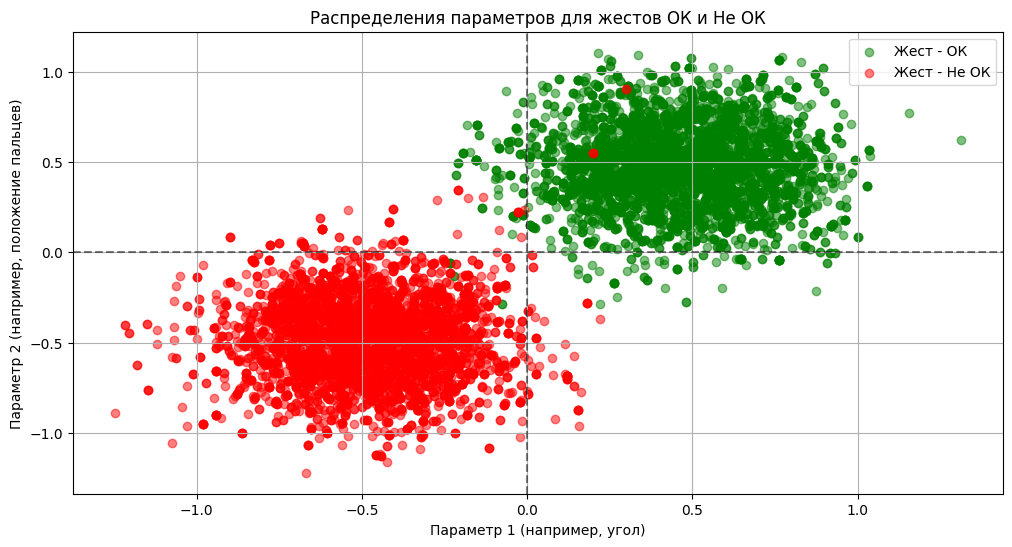

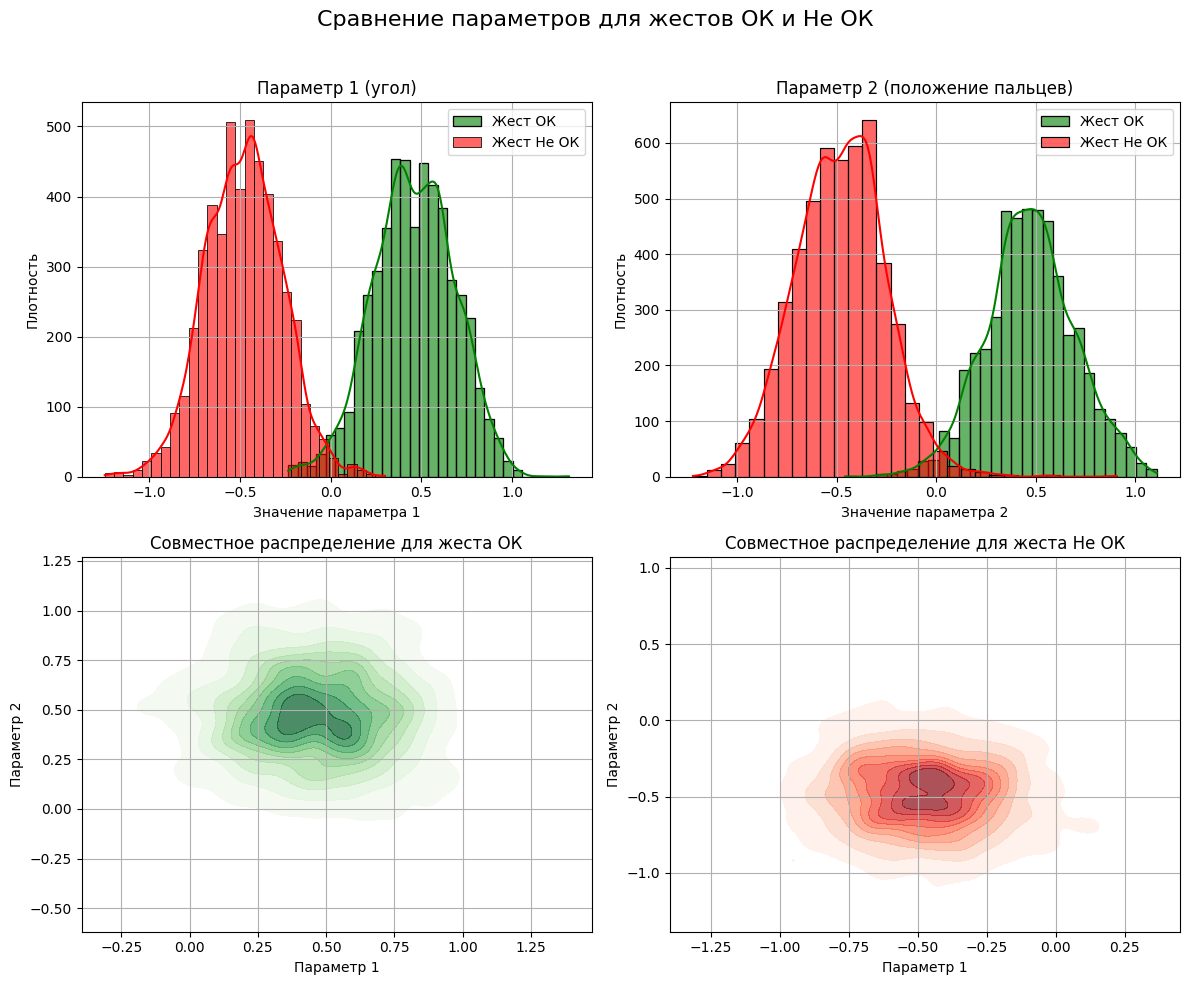

In [8]:
# Генерация данных для двух классов (жестов)
def likelihood_ok(theta):
    """Правдоподобие для жеста - ОК"""
    mean_ok = np.array([0.5, 0.5]) # Средние параметры для жеста - ОК
    return np.exp(-np.sum((theta - mean_ok) ** 2) / 0.1)

def likelihood_not_ok(theta):
    """Правдоподобие для жеста - Не ОК"""
    mean_not_ok = np.array([-0.5, -0.5]) # Средние параметры для жеста - Не ОК
    return np.exp(-np.sum((theta - mean_not_ok) ** 2) / 0.1)

def prior(theta):
    """Априорное распределение."""
    return np.exp(-np.sum(theta ** 2) / 2) # Нормальное распределение

# Целевые распределения
def target_distribution_ok(theta):
    return likelihood_ok(theta) * prior(theta)

def target_distribution_not_ok(theta):
    return likelihood_not_ok(theta) * prior(theta)

# Алгоритм Метрополиса-Хастингса
def metropolis_hastings(target_dist, n_samples, proposal_std = 0.3, dim = 2):
    samples = []
    theta = np.random.normal(0, 1, size = dim) # Начальная точка

    for _ in range(n_samples):
        theta_new = theta + np.random.normal(0, proposal_std, size = dim) # Предложение
        r = target_dist(theta_new) / target_dist(theta)
        if np.random.rand() < r:
            theta = theta_new
        samples.append(theta)
    
    return np.array(samples)

# Запуск алгоритма для двух жестов
n_samples = 5000
samples_ok = metropolis_hastings(target_distribution_ok, n_samples)
samples_not_ok = metropolis_hastings(target_distribution_not_ok, n_samples)

# Визуализация распределений параметров
plt.figure(figsize = (12, 6))
plt.scatter(samples_ok[:, 0], samples_ok[:, 1], alpha = 0.5, label = "Жест - ОК", color = "green")
plt.scatter(samples_not_ok[:, 0], samples_not_ok[:, 1], alpha = 0.5, label = "Жест - Не ОК", color = "red")
plt.axvline(0, color = "black", linestyle = "--", alpha = 0.5)
plt.axhline(0, color = "black", linestyle = "--", alpha = 0.5)
plt.title("Распределения параметров для жестов ОК и Не ОК")
plt.xlabel("Параметр 1 (например, угол)")
plt.ylabel("Параметр 2 (например, положение пальцев)")
plt.legend()
plt.grid()
plt.show()

# Гистограммы параметров
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
fig.suptitle("Сравнение параметров для жестов ОК и Не ОК", fontsize = 16)

# Параметр 1
sns.histplot(samples_ok[:, 0], bins = 30, color = "green", alpha = 0.6, label = "Жест ОК", ax = axes[0, 0], kde = True)
sns.histplot(samples_not_ok[:, 0], bins = 30, color = "red", alpha = 0.6, label = "Жест Не ОК", ax = axes[0, 0], kde = True)
axes[0, 0].set_title("Параметр 1 (угол)")
axes[0, 0].set_xlabel("Значение параметра 1")
axes[0, 0].set_ylabel("Плотность")
axes[0, 0].legend()
axes[0, 0].grid()

# Параметр 2
sns.histplot(samples_ok[:, 1], bins = 30, color = "green", alpha = 0.6, label = "Жест ОК", ax = axes[0, 1], kde = True)
sns.histplot(samples_not_ok[:, 1], bins = 30, color = "red", alpha = 0.6, label = "Жест Не ОК", ax = axes[0, 1], kde = True)
axes[0, 1].set_title("Параметр 2 (положение пальцев)")
axes[0, 1].set_xlabel("Значение параметра 2")
axes[0, 1].set_ylabel("Плотность")
axes[0, 1].legend()
axes[0, 1].grid()

# Совместное распределение: Жест ОК
sns.kdeplot(x = samples_ok[:, 0], y = samples_ok[:, 1], cmap = "Greens", fill = True, ax = axes[1, 0], alpha = 0.7)
axes[1, 0].set_title("Совместное распределение для жеста ОК")
axes[1, 0].set_xlabel("Параметр 1")
axes[1, 0].set_ylabel("Параметр 2")
axes[1, 0].grid()

# Совместное распределение: Жест Не ОК
sns.kdeplot(x = samples_not_ok[:, 0], y = samples_not_ok[:, 1], cmap = "Reds", fill = True, ax = axes[1, 1], alpha = 0.7)
axes[1, 1].set_title("Совместное распределение для жеста Не ОК")
axes[1, 1].set_xlabel("Параметр 1")
axes[1, 1].set_ylabel("Параметр 2")
axes[1, 1].grid()

plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.show()

### Алгоритм Гиббса

Еще один метод (частный случай) случайного подбора значений из распределений, который используется для генерации выборки в многомерных задачах

**Пример**: Стоит задача классификации, в которой нужно предсказать вероятность принадлежности данных к определенному классу (например, распознавание эмоций или жестов), **алгоритм Гиббса** позволяет генерировать параметры модели поочередно для каждой переменной, фиксируя другие параметры

**Как работает алгоритм?**
1. **Инициализация**. Начинаем с произвольных значений параметров. Например, для каждого параметра модели, который мы исследуем, выбираем случайное начальное значение
2. **Циклическое обновление**. Для каждого параметра поочередно вычисляем его новое значение, исходя из распределения вероятности, которое зависит от всех остальных параметров. Это обновление выполняется шаг за шагом для каждого параметра.
   
Для каждого параметра $\theta_i$ обновление выглядит следующим образом:

$$
\theta_i^{(t+1)} \sim P(\theta_i \mid \theta_{-i}^{(t)}, \text{данные})
$$

где:
- $\theta_i$ - это параметр, который обновляется
- $\theta_{-i}$ - это все остальные параметры, которые фиксированы на текущем шаге

3. **Повторение шагов**. Этот процесс продолжается, пока не будет сгенерировано достаточное количество значений параметров для построения *апостериорного распределения*

4. **Получение выборки**. После того как мы обновим все параметры несколько раз, наша выборка будет аппроксимировать *апостериорное распределение* для всех параметров модели

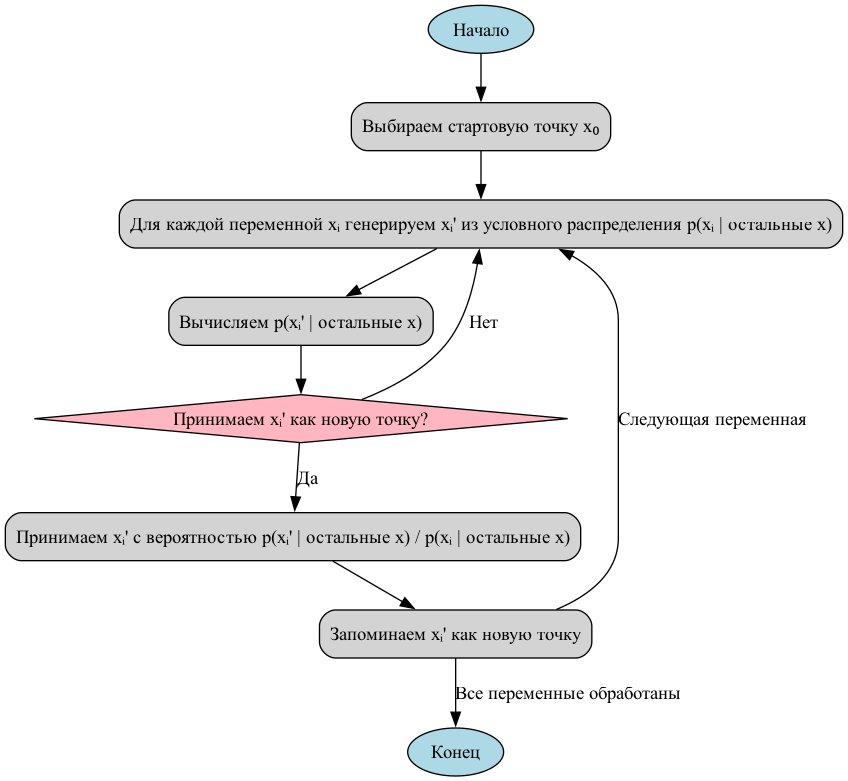

#### Задача: предсказать вероятности классов в задаче распознавания эмоций

**Постановка задачи**. Создается модель для распознавания эмоций. У нас есть 7 классов эмоций (радость, грусть, страх, гнев, удивление, отвращение, нейтральное состояние). Нам нужно сгенерировать выборку параметров модели, чтобы *апостериорное распределение* параметров лучше описывало вероятность принадлежности эмоции к определенному классу

Вместо того чтобы сразу точно вычислять все параметры для каждого класса, мы можем использовать **алгоритм Гиббса**, чтобы поочередно обновлять каждый параметр и получать их возможные значения. Это будет происходить итерационно, шаг за шагом, и в итоге мы получим приближенную картину того, какие параметры для каждого класса (например, для радости, грусти, страха и т.д.) наиболее вероятны

**Целевое распределение**. Необходимо апостериорное распределение параметров $\pi(\theta)$, которое пропорционально:

$$
\pi(\theta) \propto P(\text{данные} \mid \theta) \times P(\theta)
$$

где:
- $P(\text{данные} \mid \theta)$ - правдоподобие данных при параметрах $\theta$
- $P(\theta)$ - априорное распределение параметров

С помощью **алгоритма Гиббса** мы будем обновлять параметры $\theta$ для каждого класса эмоций, чтобы лучше понять, какие параметры наиболее вероятны для классификации каждого из 7 классов. Это позволит нашей модели эффективно предсказать эмоции

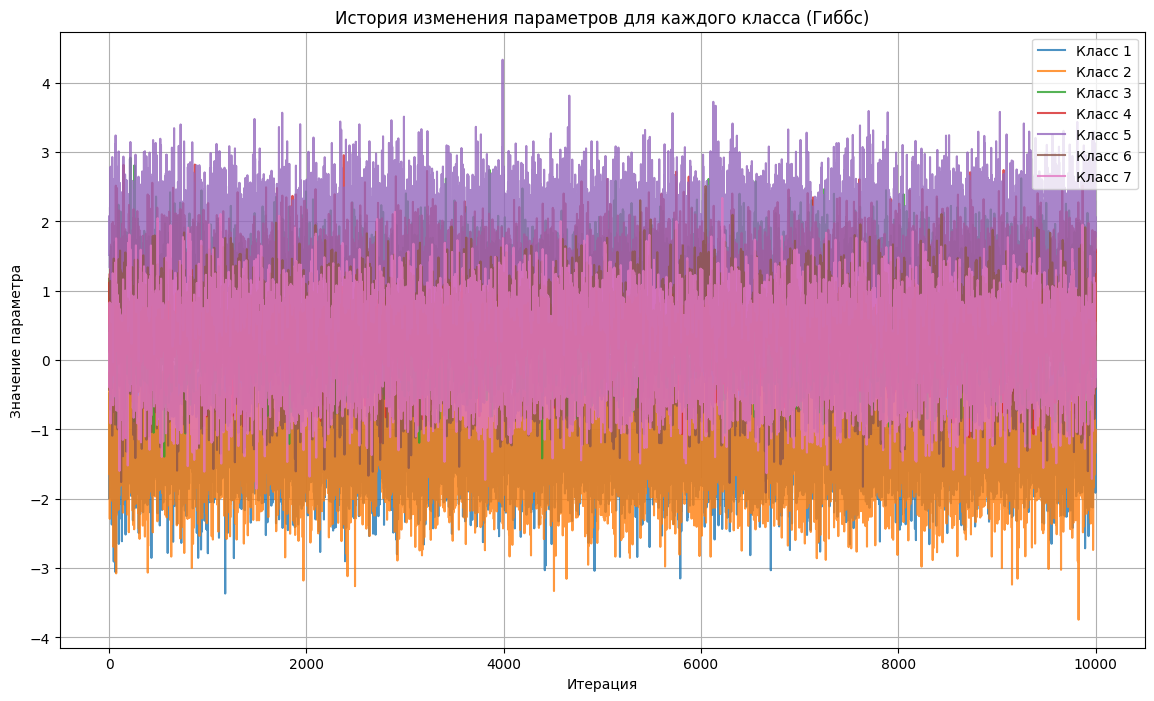

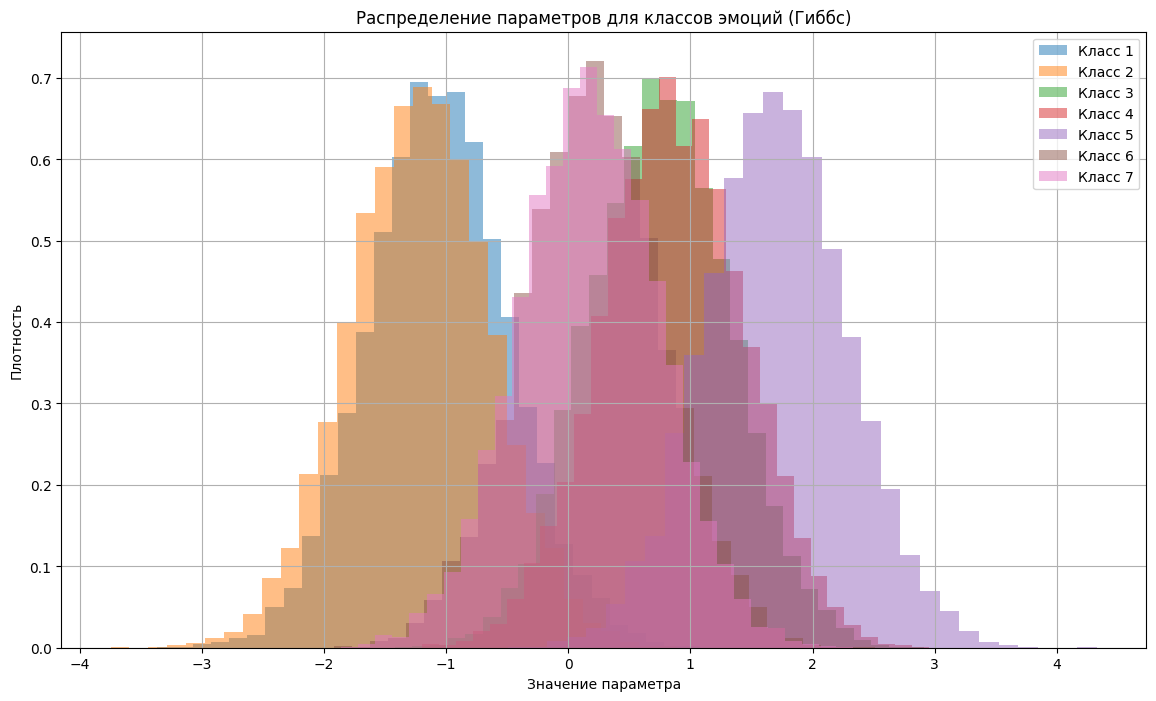

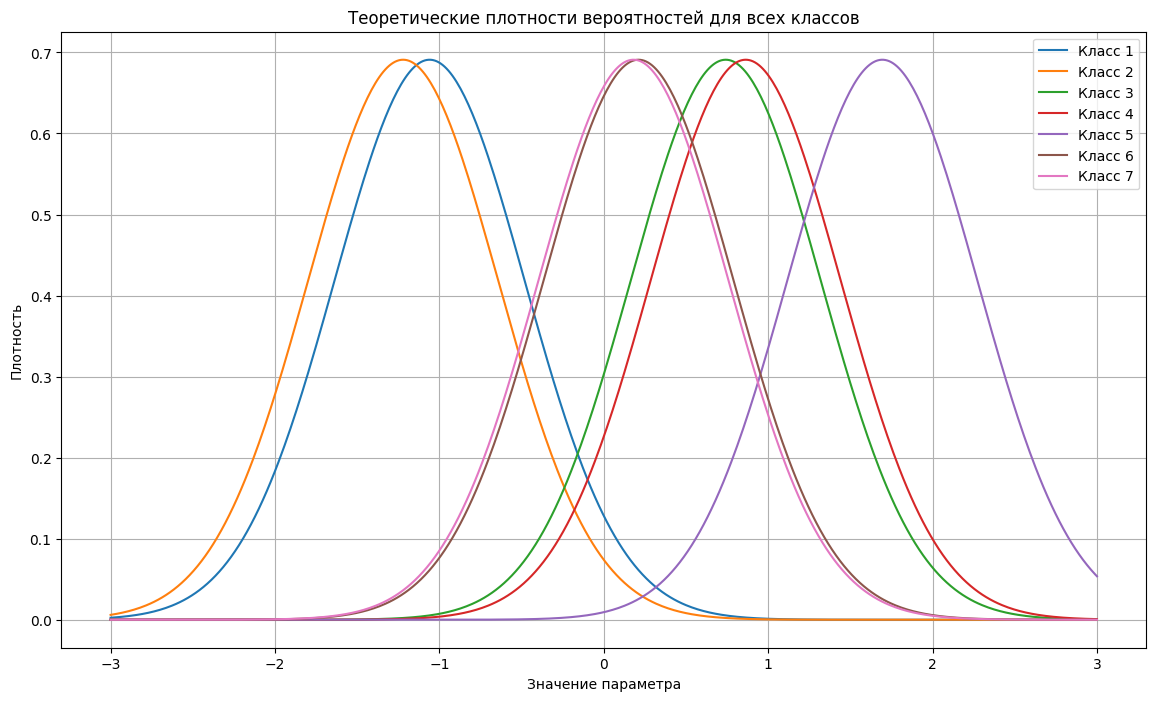

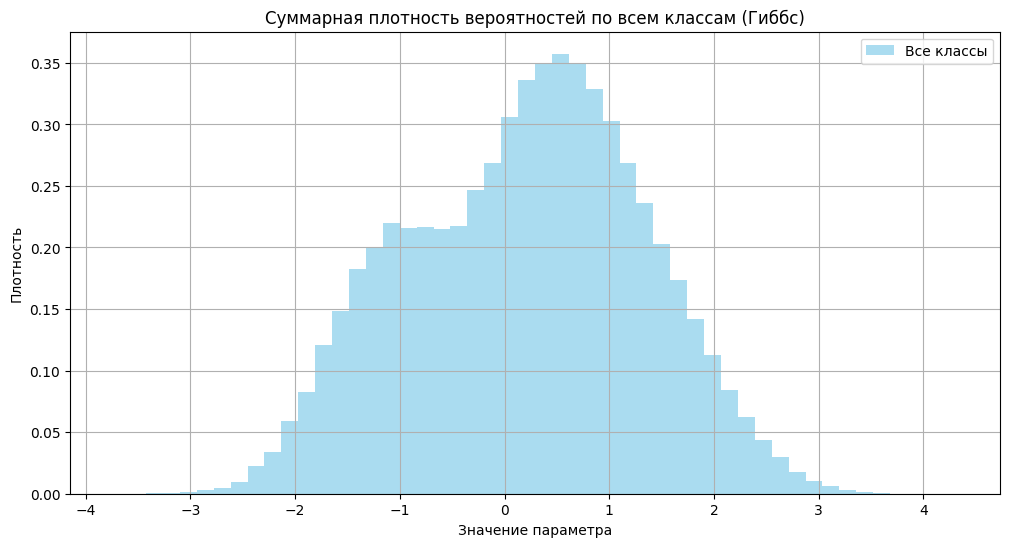

In [9]:
# Эмуляция данных
data = np.random.normal(0, 1, size = (7,)) # Данные для 7 классов

# Параметры апостериорного распределения для каждого класса
def conditional_distribution(data_i):
    posterior_mean = (2/3) * data_i # Среднее апостериорного распределения
    posterior_std = np.sqrt(1/3) # СКО апостериорного распределения
    return posterior_mean, posterior_std

# Алгоритм Гиббса
def gibbs_sampling(data, n_samples):
    n_classes = data.shape[0]
    samples = []
    # Инициализация начальных значений параметров
    theta = np.random.normal(0, 1, size = n_classes)
    
    for _ in range(n_samples):
        # Последовательно обновляем каждый параметр
        for i in range(n_classes):
            mu_i, sigma_i = conditional_distribution(data[i])
            theta[i] = np.random.normal(mu_i, sigma_i)
        samples.append(theta.copy())
    
    return np.array(samples)

# Генерация выборок
samples = gibbs_sampling(data, n_samples = 10000)

# Визуализация истории параметров для каждого класса
plt.figure(figsize = (14, 8))
for i in range(data.shape[0]):
    plt.plot(samples[:, i], label = f"Класс {i+1}", alpha = 0.8)
plt.title("История изменения параметров для каждого класса (Гиббс)")
plt.xlabel("Итерация")
plt.ylabel("Значение параметра")
plt.legend()
plt.grid()
plt.show()

# Распределение параметров для всех классов
plt.figure(figsize = (14, 8))
for i in range(data.shape[0]):
    plt.hist(samples[:, i], bins = 30, alpha = 0.5, label = f"Класс {i+1}", density = True)
plt.title("Распределение параметров для классов эмоций (Гиббс)")
plt.xlabel("Значение параметра")
plt.ylabel("Плотность")
plt.legend()
plt.grid()
plt.show()

# Сравнение плотностей для всех классов
plt.figure(figsize = (14, 8))
x = np.linspace(-3, 3, 500)
for i in range(data.shape[0]):
    mu, sigma = conditional_distribution(data[i])
    plt.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu)/sigma)**2), label = f"Класс {i+1}")
plt.title("Теоретические плотности вероятностей для всех классов")
plt.xlabel("Значение параметра")
plt.ylabel("Плотность")
plt.legend()
plt.grid()
plt.show()

# Обобщённая плотность вероятностей
all_samples = samples.flatten()
plt.figure(figsize = (12, 6))
plt.hist(all_samples, bins = 50, density = True, alpha = 0.7, color = "skyblue", label = "Все классы")
plt.title("Суммарная плотность вероятностей по всем классам (Гиббс)")
plt.xlabel("Значение параметра")
plt.ylabel("Плотность")
plt.legend()
plt.grid()
plt.show()

### Задача: предсказать вероятности классов в задаче распознавания жестов

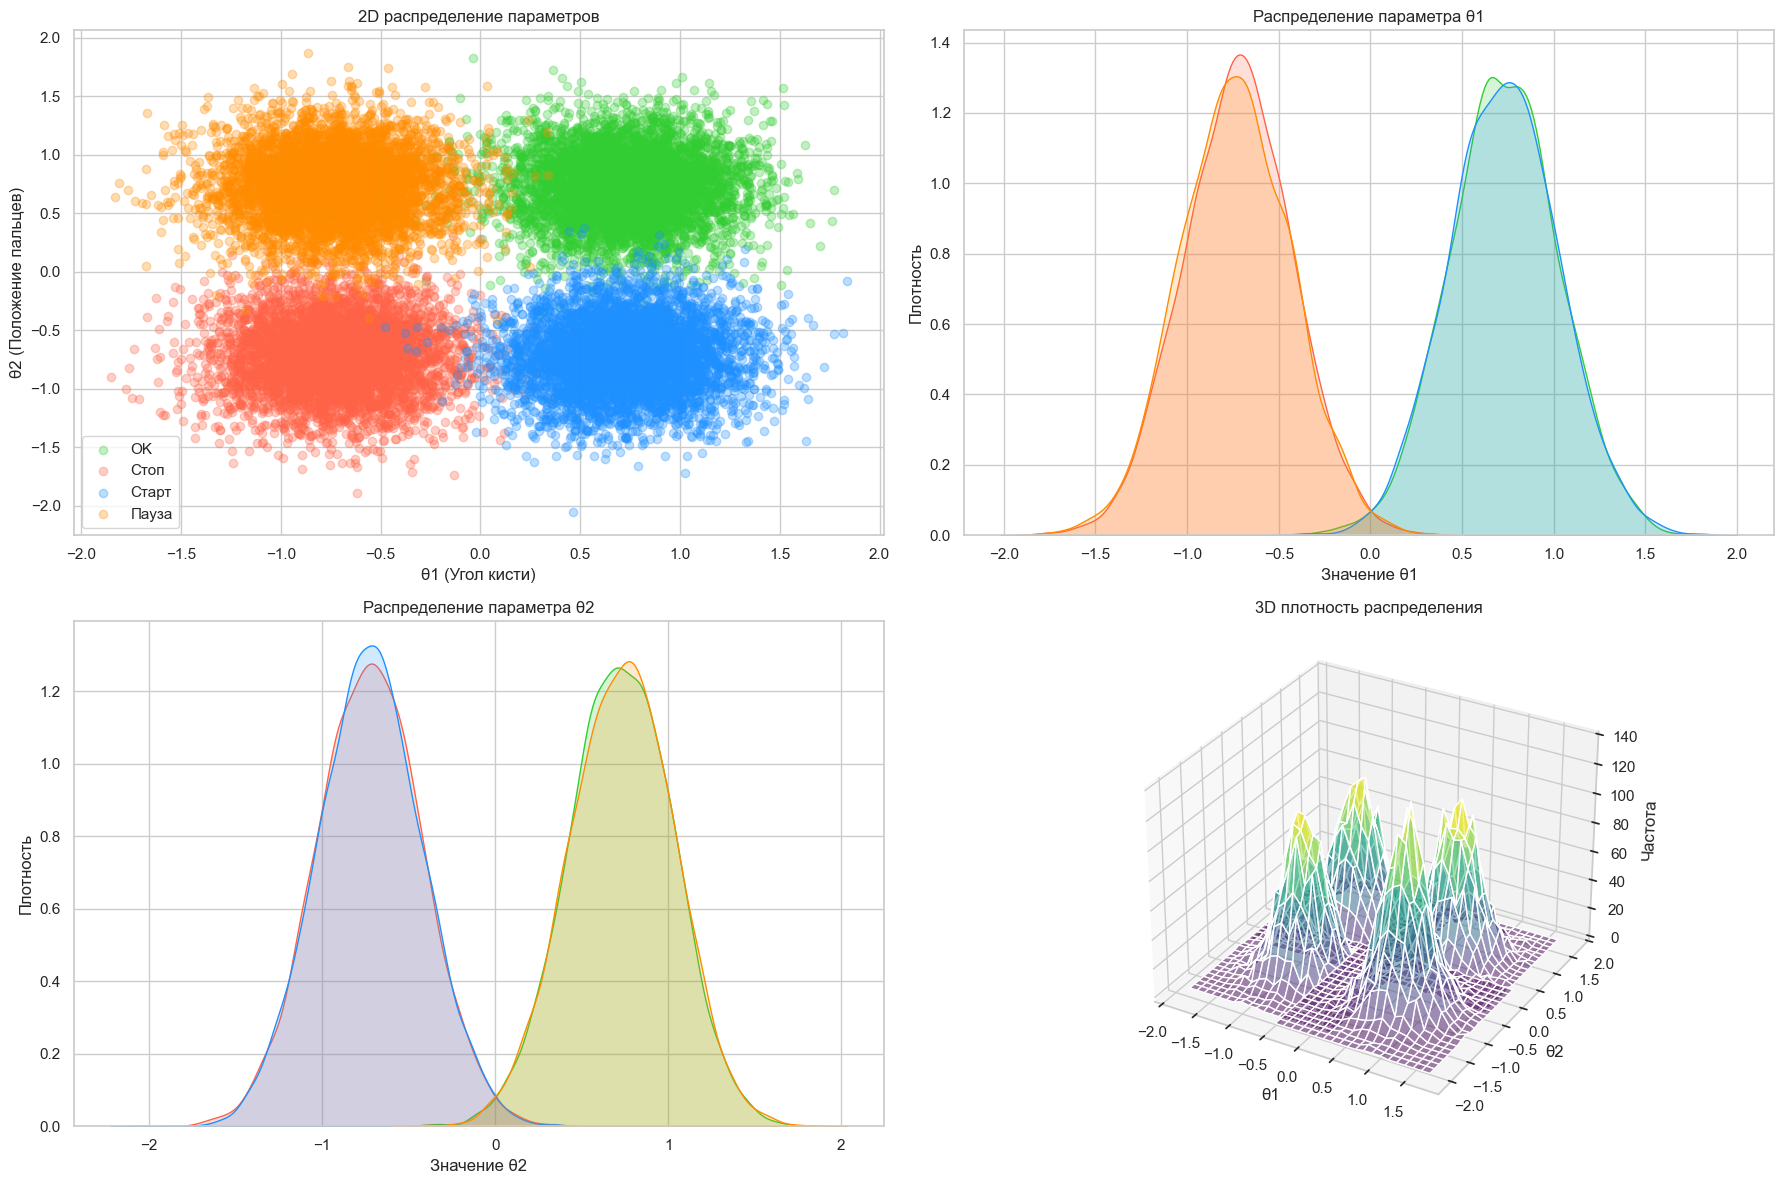

In [10]:
# Конфигурация графиков
sns.set(style="whitegrid")
plt.rcParams['font.size'] = 12

# Параметры модели
class Config:
    n_classes = 4
    n_params = 2
    means = {
        "OK": [0.8, 0.8],
        "Стоп": [-0.8, -0.8],
        "Старт": [0.8, -0.8],
        "Пауза": [-0.8, 0.8]
    }
    colors = {
        "OK": "limegreen",
        "Стоп": "tomato",
        "Старт": "dodgerblue",
        "Пауза": "darkorange"
    }
    prior_var = 1.0
    likelihood_var = 0.1

def conditional_distribution(class_type, param_idx):
    """Условное распределение для параметра"""
    posterior_var = 1/(1/Config.prior_var + 1/Config.likelihood_var)
    posterior_mean = (Config.means[class_type][param_idx]/Config.likelihood_var) * posterior_var
    return posterior_mean, np.sqrt(posterior_var)

def gibbs_sampler(n_samples = 5000, burn_in = 1000):
    """Алгоритм Гиббса для 4 классов"""
    samples = {cls: [] for cls in Config.means}
    theta = {cls: np.random.normal(0, 1, Config.n_params) for cls in Config.means}
    
    for iter in range(n_samples + burn_in):
        for cls in Config.means:
            for param in range(Config.n_params):
                mu, sigma = conditional_distribution(cls, param)
                theta[cls][param] = np.random.normal(mu, sigma)
                
            if iter >= burn_in:
                samples[cls].append(theta[cls].copy())
                
    return {cls: np.array(samples[cls]) for cls in samples}

# Генерация данных
samples = gibbs_sampler()

# Визуализация
fig = plt.figure(figsize = (18, 12))

# 2D распределения параметров
ax1 = fig.add_subplot(221)
for cls in Config.means:
    ax1.scatter(samples[cls][:,0], samples[cls][:,1], alpha = 0.3, label = cls, c = Config.colors[cls])
ax1.set_title("2D распределение параметров")
ax1.set_xlabel("θ1 (Угол кисти)")
ax1.set_ylabel("θ2 (Положение пальцев)")
ax1.legend()

# Маргинальные распределения
ax2 = fig.add_subplot(222)
for cls in Config.means:
    sns.kdeplot(samples[cls][:,0], fill = True, alpha = 0.2, label = cls, color = Config.colors[cls], ax = ax2)
ax2.set_title("Распределение параметра θ1")
ax2.set_xlabel("Значение θ1")
ax2.set_ylabel("Плотность")

ax3 = fig.add_subplot(223)
for cls in Config.means:
    sns.kdeplot(samples[cls][:,1], fill = True, alpha = 0.2, label = cls, color = Config.colors[cls], ax = ax3)
ax3.set_title("Распределение параметра θ2")
ax3.set_xlabel("Значение θ2")
ax3.set_ylabel("Плотность")

# 3D совместное распределение
ax4 = fig.add_subplot(224, projection = '3d')
for cls in Config.means:
    x = samples[cls][:,0]
    y = samples[cls][:,1]
    hist, xedges, yedges = np.histogram2d(x, y, bins = 20)
    
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1])
    ax4.plot_surface(xpos, ypos, hist, cmap = "viridis", alpha = 0.5, label = cls)

ax4.set_title("3D плотность распределения")
ax4.set_xlabel("θ1")
ax4.set_ylabel("θ2")
ax4.set_zlabel("Частота")

plt.tight_layout()
plt.show()

# Семинар 3

4. **Марковские цепи и их реализация.**
   - Реализация и оптимизация алгоритмов Марковских цепей Монте-Карло с использованием PyTorch.
   - Практические задания по моделированию сложных распределений и оценке параметров моделей.

## Прогнозирование загрузки серверов с использованием MЦMК

### Описание задачи

Задача прогнозирования загрузки серверов на основе наблюдаемых данных. В реальных условиях, таких как управление облачными сервисами (например, Яндекс.Облако), часто требуется строить прогнозы загрузки на основе неполных или зашумленных данных

Предполагается, что зависимость между временем работы сервера и его загрузкой можно описать линейной моделью:

$$
y = w_0 \times X + w_1 + \epsilon
$$

где:
- $y$ - наблюдаемая загрузка сервера
- $X$ - время
- $w_0$ - наклон (темп изменения загрузки)
- $w_1$ - смещение (начальное значение загрузки)
- $\epsilon$ - шум, имеющий нормальное распределение

### Цель

Определить параметры $w_0$ и $w_1$, которые лучше всего описывают данные. Поскольку данные зашумлены, используется байесовский подход для оценки параметров. С помощью алгоритма Метрополиса-Хастингса можно получить апостериорное распределение параметров.

### Шаги решения

1. **Синтетические данные**
    - Генерируем искусственные данные, чтобы смоделировать реальные наблюдения загрузки серверов. Эти данные содержат шум для приближения реальных условий
2. **Модель апостериорного распределения**
   - Апостериорная вероятность параметров рассчитывается как произведение априорного распределения и правдоподобия:
     $$
     P(w|X, y) \propto P(y|X, w) \times P(w)
     $$
   - Используем нормальное априорное распределение для параметров $w_0$ и $w_1$, а правдоподобие моделируем как нормальное распределение ошибок
3. **Алгоритм Метрополиса-Хастингса**
   - Инициализируем параметры случайным образом
   - Предлагаем новые значения параметров на каждой итерации с использованием нормального распределения
   - Принимаем или отклоняем новые параметры в зависимости от отношения вероятностей
4. **Анализ результатов**
   - Строим графики выборки параметров для визуализации сходимости
   - Строим гистограммы, чтобы увидеть апостериорное распределение параметров
   - Используем выборку параметров для построения прогнозов загрузки серверов

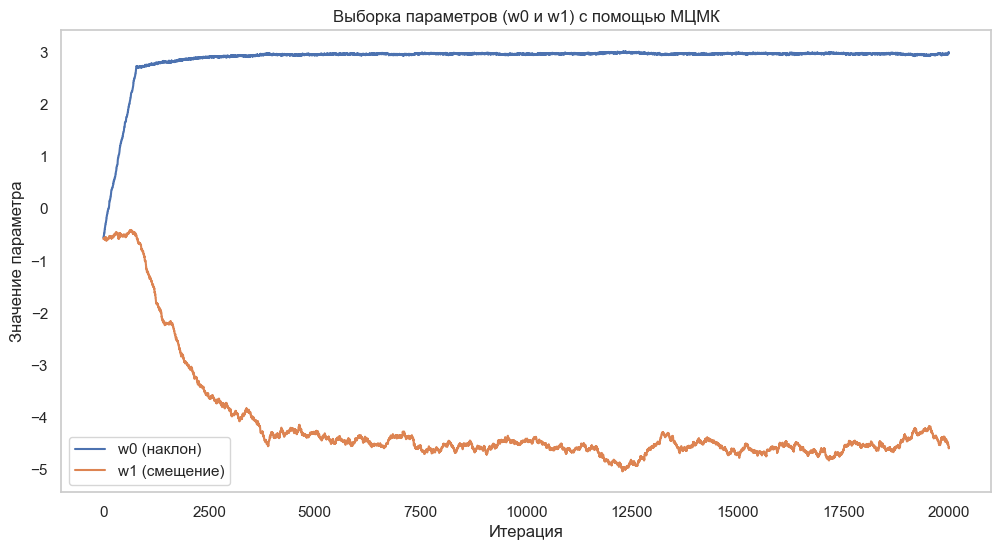

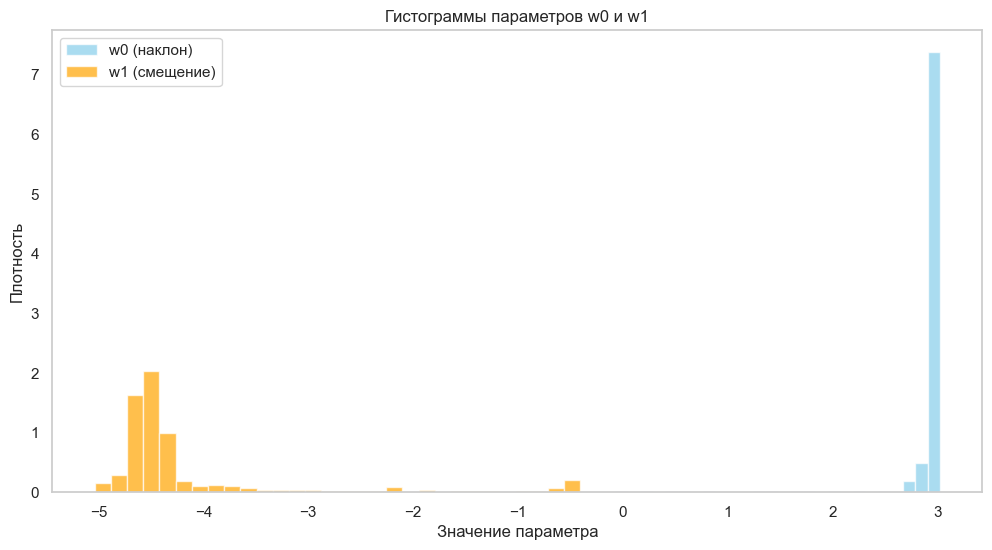

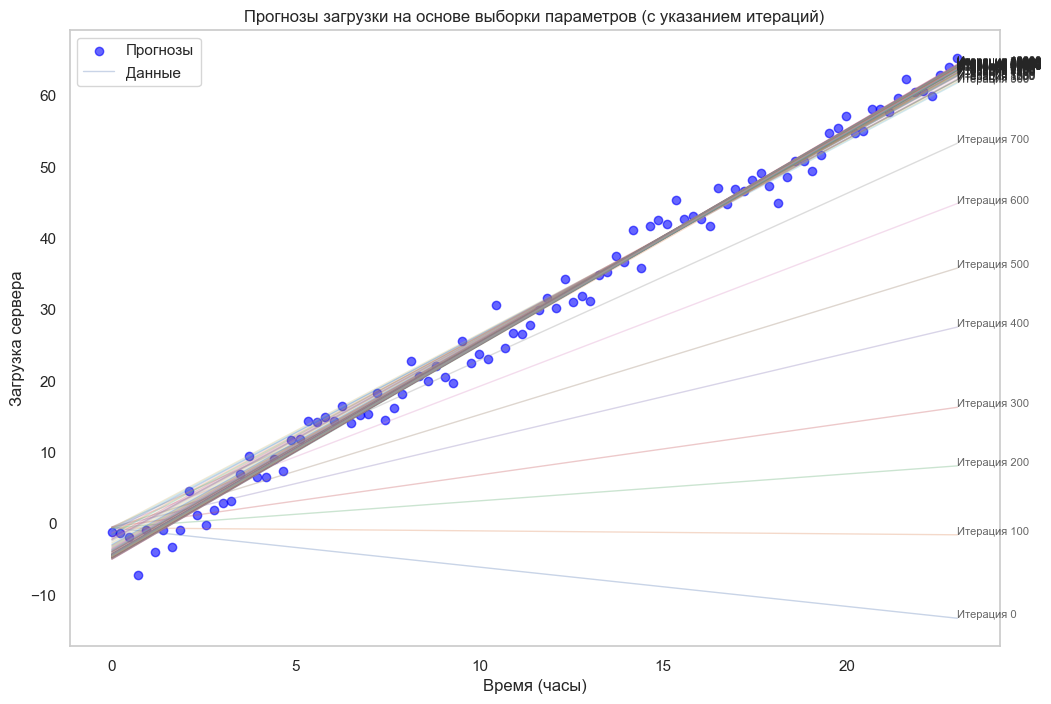

In [21]:
# Генерация данных
torch.manual_seed(42)
n_points = 100
X = torch.linspace(0, 23, n_points) # Время (часы)
y = 3 * X - 5 + torch.normal(0, 2, size=X.shape) # Нагрузка сервера (с неизвестными параметрами)

# Функция апостериорной вероятности
def log_prob(w):
    prior = -0.5 * torch.sum(w**2) # Априорное распределение N(0,1)
    likelihood = -0.5 * torch.sum((y - (w[0] * X + w[1]))**2) # Правдоподобие
    return prior + likelihood

# Алгоритм Метрополиса-Хастингса
def mcmc(n_samples = 20000, proposal_std = 0.01):
    samples = []
    w_curr = torch.randn(2) # Начальные параметры

    for _ in range(n_samples):
        w_prop = w_curr + torch.randn(2) * proposal_std
        log_ratio = log_prob(w_prop) - log_prob(w_curr)

        if torch.log(torch.rand(1)) < log_ratio:
            w_curr = w_prop

        samples.append(w_curr.clone())

    return torch.stack(samples)

# Запуск МЦМК
samples = mcmc()

# Визуализация выборки параметров
plt.figure(figsize = (12, 6))
plt.plot(samples[:, 0].numpy(), label = "w0 (наклон)")
plt.plot(samples[:, 1].numpy(), label = "w1 (смещение)")
plt.title("Выборка параметров (w0 и w1) с помощью МЦМК")
plt.xlabel("Итерация")
plt.ylabel("Значение параметра")
plt.legend()
plt.grid()
plt.show()

# Построение гистограмм параметров
plt.figure(figsize = (12, 6))
plt.hist(samples[:, 0].numpy(), bins = 30, alpha = 0.7, label = "w0 (наклон)", color = "skyblue", density = True)
plt.hist(samples[:, 1].numpy(), bins = 30, alpha = 0.7, label = "w1 (смещение)", color = "orange", density = True)
plt.title("Гистограммы параметров w0 и w1")
plt.xlabel("Значение параметра")
plt.ylabel("Плотность")
plt.legend()
plt.grid()
plt.show()

# Прогнозы на основе выборки параметров
step = 100 # Шаг для прореживания прогнозов
predictions = [
    (samples[i, 0] * X + samples[i, 1], f"Итерация {i}")
    for i in range(0, len(samples), step)
]

plt.figure(figsize = (12, 8))
plt.scatter(X.numpy(), y.numpy(), label = "Наблюдения о сервере", alpha = 0.6, color = "blue")

# Добавляем линии с подписями итераций
for pred, label in predictions:
    plt.plot(X.numpy(), pred.numpy(), alpha = 0.3, linewidth = 1)
    plt.text(X[-1].item(), pred[-1].item(), label, fontsize = 8, alpha = 0.7)

# Оформление графика
plt.title("Прогнозы загрузки на основе выборки параметров (с указанием итераций)")
plt.xlabel("Время (часы)")
plt.ylabel("Загрузка сервера")
plt.legend(["Прогнозы", "Данные"], loc = "upper left")
plt.grid()
plt.show()

## Оптимизация динамического ценообразования с помощью МЦМК

### Описание задачи

В сфере доставки часто возникает необходимость адаптировать цены в зависимости от текущих условий, чтобы:
- Увеличить прибыль
- Снизить нагрузку на систему доставки
- Удовлетворить высокий спрос в определенные периоды

**Пример.** В Яндекс.Доставке требуется определять оптимальную цену услуги, учитывая такие факторы, как сезонность, погодные условия, и исторические данные

Целевая зависимость может быть описана следующей моделью:

$$
\text{Цена} = w_0 + w_1 \times \text{Спрос} + w_2 \times \text{Погода} + w_3 \times \text{Сезонность} + \epsilon
$$

где:
- $\text{Цена}$ - оптимальная цена доставки
- $\text{Спрос}$ - текущий спрос на услуги доставки
- $\text{Погода}$ - метеоусловия, отражающие сложности доставки (например, дождь, снег, гололед)
- $\text{Сезонность}$ - сезонные колебания, такие как праздничные периоды или выходные
- $w_0, w_1, w_2, w_3$ - параметры модели, которые мы хотим оценить
- $\epsilon$ - случайный шум

### Цель

Оценить параметры модели, которые наилучшим образом описывают зависимость цены от спроса, погоды и сезонности, чтобы предложить оптимальную цену для доставки

### Шаги решения
1. **Сбор данных**
    - Исторические данные о цене доставки, спросе, погодных условиях, и сезонных факторах

2. **Построение модели**
    - Модель ценообразования основана на линейной комбинации факторов
    - Использовать байесовский подход для учета неопределенности в данных и параметрах

3. **Алгоритм Метрополиса-Хастингса**
    - Генерация выборки параметров $w_0, w_1, w_2, w_3$ с помощью МЦМК, чтобы оценить апостериорное распределение

4. **Визуализация и анализ**
   - Построить графики выборки параметров, чтобы оценить их апостериорное распределение
   - Проанализировать прогнозируемые цены для различных условий

5. **Прогнозирование цены**
   - Использовать полученные параметры для определения оптимальной цены доставки в зависимости от текущих факторов

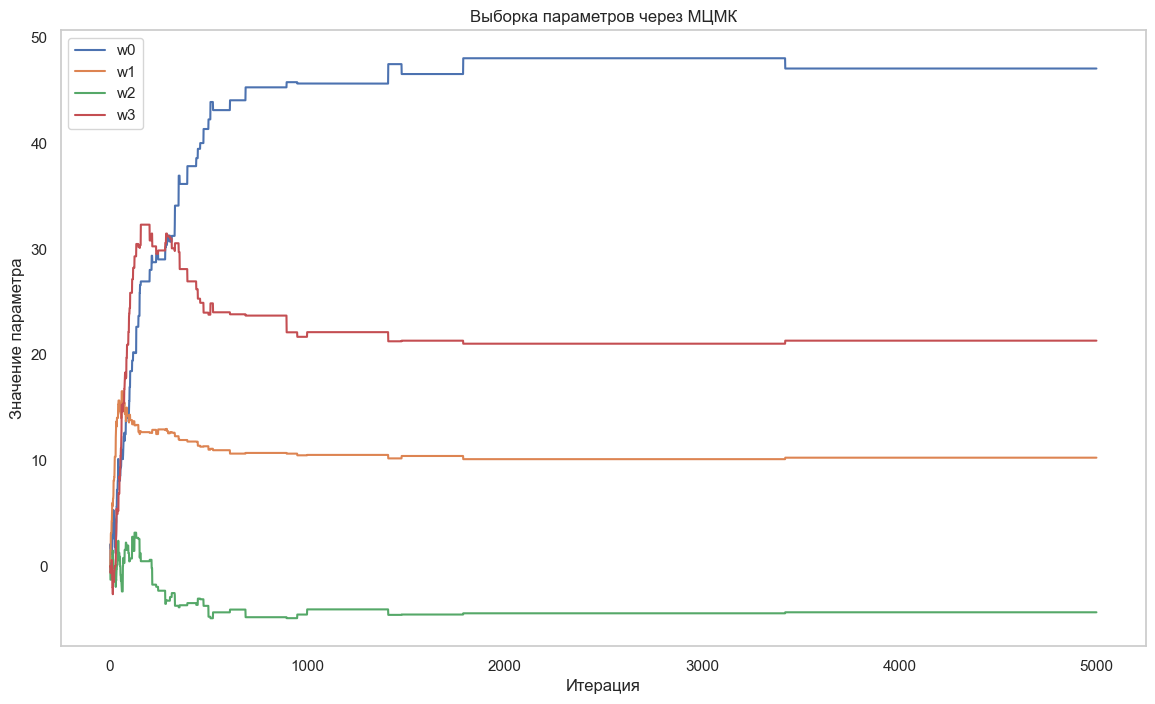

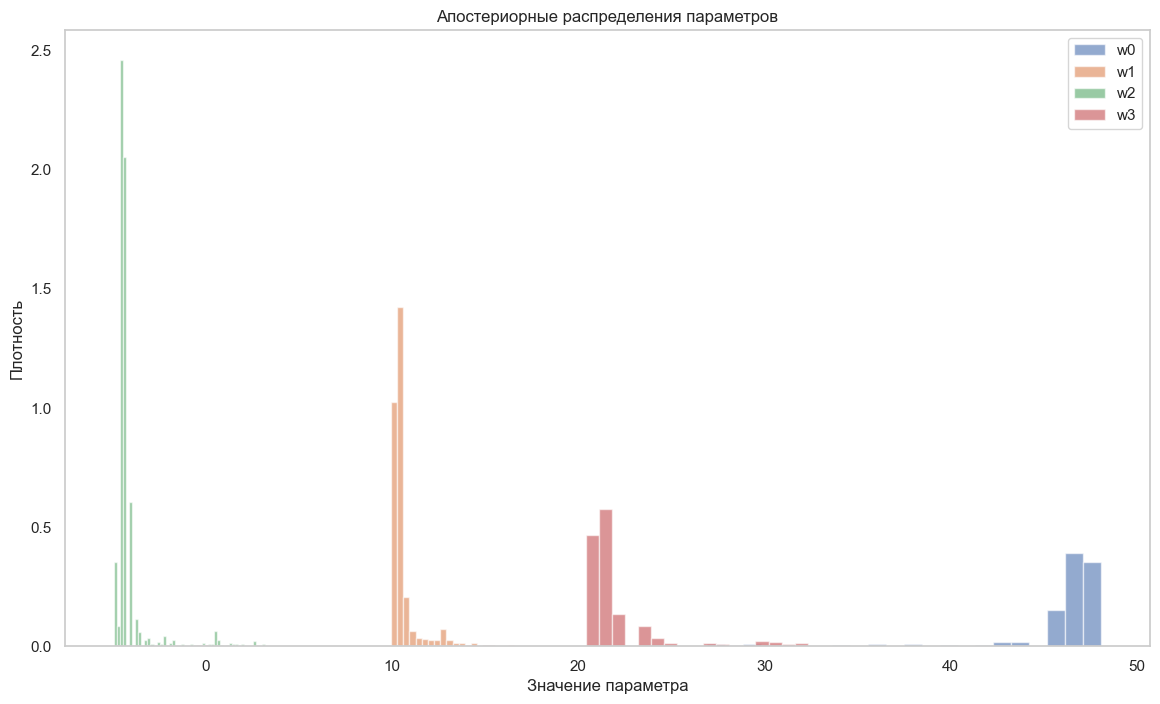

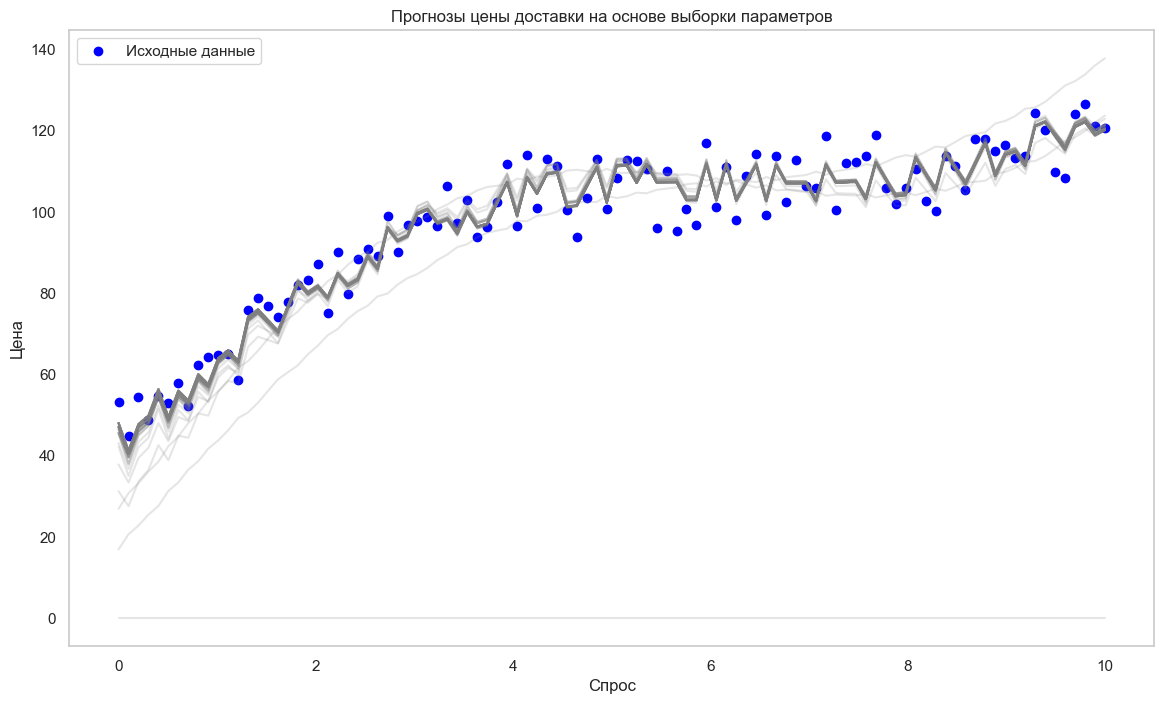

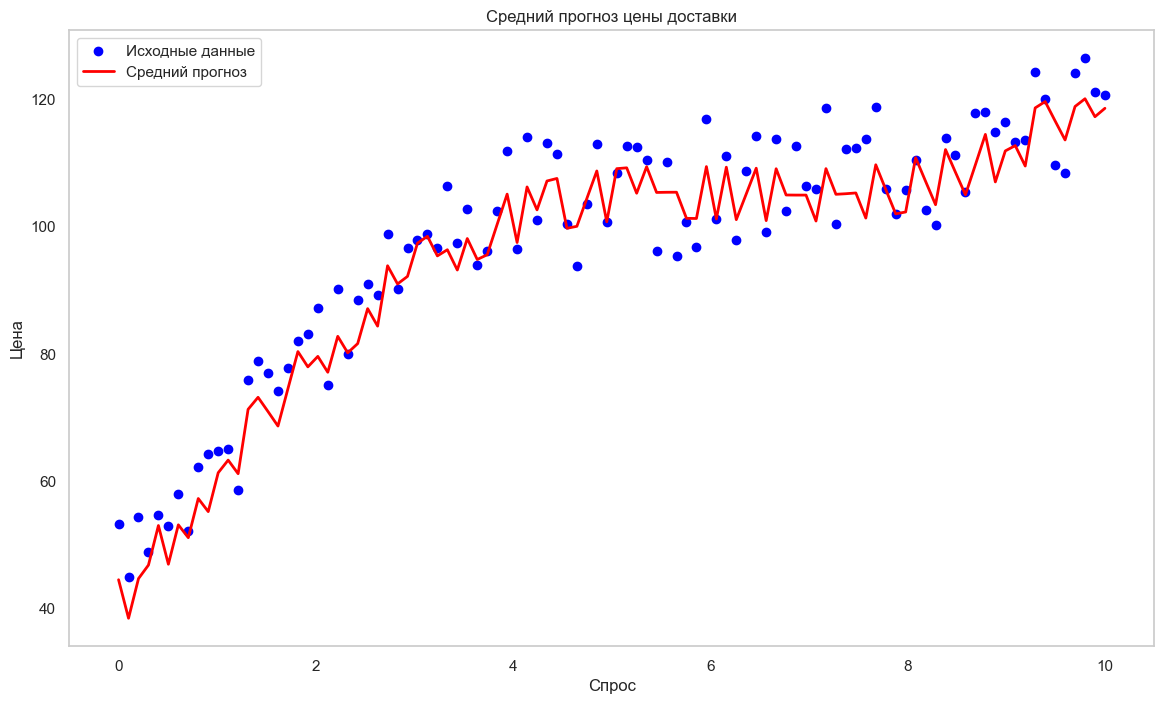

In [26]:
# Генерация синтетических данных
torch.manual_seed(42)
n_samples = 100
demand = torch.linspace(0, 10, n_samples) # Спрос
weather = torch.randint(0, 3, size = (n_samples,)) # Погодные условия: 0 - хорошая, 1 - дождь, 2 - снег
seasonality = torch.sin(demand / 2) # Сезонность

# Реальные параметры модели
true_params = torch.tensor([50.0, 10.0, -5.0, 20.0]) # w0, w1, w2, w3
noise = torch.normal(0, 5, size = (n_samples,)) # Шум
price = (
    true_params[0]
    + true_params[1] * demand
    + true_params[2] * weather
    + true_params[3] * seasonality
    + noise
)

# Логарифм функции правдоподобия
def log_likelihood(w):
    prediction = w[0] + w[1] * demand + w[2] * weather + w[3] * seasonality
    return -0.5 * torch.sum((price - prediction) ** 2)

# Логарифм априорного распределения
def log_prior(w):
    return -0.5 * torch.sum(w**2) # Стандартное нормальное распределение

# Целевая функция: логарифм апостериорного распределения
def log_posterior(w):
    return log_prior(w) + log_likelihood(w)

# Алгоритм Метрополиса-Хастингса
def metropolis_hastings(n_iterations = 5000, proposal_std = 1.0):
    samples = []
    w_curr = torch.zeros(4) # Инициализация параметров
    for i in range(n_iterations):
        w_prop = w_curr + torch.normal(0, proposal_std, size=w_curr.shape) # Предложение
        log_ratio = log_posterior(w_prop) - log_posterior(w_curr)
        if torch.log(torch.rand(1)) < log_ratio:
            w_curr = w_prop # Принимаем новое значение
        samples.append(w_curr.clone())
    return torch.stack(samples)

# Запуск МЦМК
n_iterations = 5000
samples = metropolis_hastings(n_iterations = n_iterations)

# Визуализация выборки параметров
param_names = ["w0", "w1", "w2", "w3"]
plt.figure(figsize = (14, 8))
for i in range(4):
    plt.plot(samples[:, i], label = f"{param_names[i]}")
plt.title("Выборка параметров через МЦМК")
plt.xlabel("Итерация")
plt.ylabel("Значение параметра")
plt.legend()
plt.grid()
plt.show()

# Апостериорные распределения параметров
plt.figure(figsize = (14, 8))
for i in range(4):
    plt.hist(samples[:, i].numpy(), bins = 50, alpha = 0.6, label = f"{param_names[i]}", density = True)
plt.title("Апостериорные распределения параметров")
plt.xlabel("Значение параметра")
plt.ylabel("Плотность")
plt.legend()
plt.grid()
plt.show()

# Прогноз цены на основе выборки параметров
predictions = []
for sample in samples[::100]: # Каждая 100-я выборка
    pred = sample[0] + sample[1] * demand + sample[2] * weather + sample[3] * seasonality
    predictions.append(pred)

plt.figure(figsize = (14, 8))
for pred in predictions:
    plt.plot(demand, pred, color = "gray", alpha = 0.2)
plt.scatter(demand, price, color = "blue", label = "Исходные данные")
plt.title("Прогнозы цены доставки на основе выборки параметров")
plt.xlabel("Спрос")
plt.ylabel("Цена")
plt.legend()
plt.grid()
plt.show()

# Средний прогноз
mean_prediction = torch.mean(torch.stack(predictions), dim = 0)
plt.figure(figsize = (14, 8))
plt.scatter(demand, price, color = "blue", label = "Исходные данные")
plt.plot(demand, mean_prediction, color = "red", label = "Средний прогноз", linewidth = 2)
plt.title("Средний прогноз цены доставки")
plt.xlabel("Спрос")
plt.ylabel("Цена")
plt.legend()
plt.grid()
plt.show()

## Классификация типов пользователей

### Описание задачи

Необходимо классифицировать пользователей по трем типам (например, типы могут означать различные группы: моложе 30 лет, 30-50 лет, старше 50 лет), используя данные о пользователях, такие как:

- **Возраст**
- **Пол**
- **Часовой пояс**
- **Местоположение**
- **Активность**
- **Доход**
- **Интересы**

Эти данные могут быть использованы для различных бизнес-задач, например, для таргетирования рекламных кампаний, прогнозирования предпочтений пользователей или персонализированного предложений продуктов и услуг

### Цель

Построение модели классификации, которая на основе предоставленных данных (возраст, пол, местоположение и т.д.) будет предсказывать тип пользователя. В данной задаче для классификации используется **алгоритм Марковских цепей Монте-Карло**

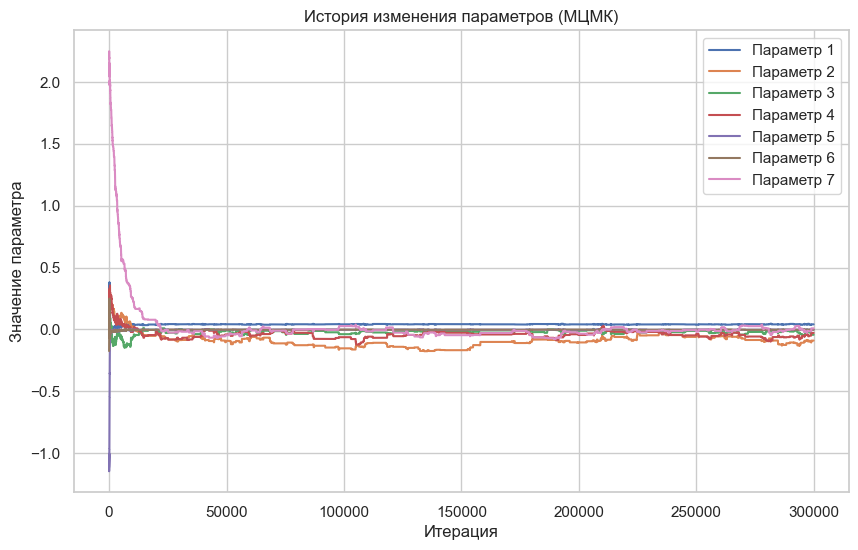

Прогнозы классов пользователей:
tensor([2, 2, 1, 1, 2, 0, 1, 2, 1, 1])
Точность: 0.8630


In [33]:
# Установка случайного состояния для воспроизводимости
np.random.seed(42)
torch.manual_seed(42)

# Количество пользователей
n_samples = 1000

# Данные о возрасте
age = np.random.randint(18, 70, size = n_samples)

# Данные о поле
gender = np.random.choice(["Мужчина", "Женщина"], size = n_samples)

# Данные о часовом поясе
timezone = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8], size = n_samples) # Пример часовых поясов от 0 до 8

# Данные о географическом местоположении
locations = np.random.choice(["Москва", "Петербург", "Новосибирск", "Екатеринбург", "Казань"], size = n_samples)

# Данные о показателе активности (от 1 до 100 сообщений в месяц)
activity = np.random.randint(1, 100, size = n_samples)

# Данные о среднем доходе (в тысячах рублей)
income = np.random.randint(30, 150, size = n_samples)

# Данные о интересах пользователей
interests = np.random.choice(["Спорт", "Технологии", "Путешествия", "Кулинария", "Музыка"], size = n_samples)

# Создание целевой переменной (тип пользователя)
user_type = np.array([0 if a < 30 else 1 if 30 <= a < 50 else 2 for a in age])

# DataFrame
data = pd.DataFrame({
    "Возраст": age,
    "Пол": gender,
    "Часовой пояс": timezone,
    "Местоположение": locations,
    "Активность": activity,
    "Доход": income,
    "Интересы": interests,
    "Тип пользователя": user_type
})

# Категориальные переменные (Пол, Местоположение, Интересы)
le_gender = LabelEncoder()
data["Пол"] = le_gender.fit_transform(data["Пол"])

le_location = LabelEncoder()
data["Местоположение"] = le_location.fit_transform(data["Местоположение"])

le_interests = LabelEncoder()
data["Интересы"] = le_interests.fit_transform(data["Интересы"])

# Определение функции правдоподобия и априорного распределения для МЦМК
def log_prob(w, X, y):
    # Априорное распределение
    prior = -0.5 * torch.sum(w**2) # N(0,1) prior
    
    # Лог-правдоподобие (линейная модель)
    predictions = torch.matmul(X, w)
    likelihood = -0.5 * torch.sum((y - predictions)**2)
    
    return prior + likelihood

# Алгоритм Метрополиса-Хастингса для МЦМК
def mcmc(n_samples, X, y, proposal_std = 0.01):
    samples = []
    w_curr = torch.randn(X.shape[1]) # Начальная точка
    
    for _ in range(n_samples):
        w_prop = w_curr + torch.randn(X.shape[1]) * proposal_std # Предложение
        log_ratio = log_prob(w_prop, X, y) - log_prob(w_curr, X, y)
        
        if torch.log(torch.rand(1)) < log_ratio:
            w_curr = w_prop
            
        samples.append(w_curr.clone())
    
    return torch.stack(samples)

# Подготовка данных
X = data.drop(columns = ["Тип пользователя"]).values
X = torch.tensor(X, dtype = torch.float32)

y = data["Тип пользователя"].values
y = torch.tensor(y, dtype = torch.float32)

# Запуск МЦМК
n_samples = 300000
samples = mcmc(n_samples, X, y)

# Визуализация истории изменения параметров (например, для одного из параметров)
plt.figure(figsize = (10, 6))
for i in range(samples.shape[1]):
    plt.plot(samples[:, i].numpy(), label = f"Параметр {i+1}")
plt.title("История изменения параметров (МЦМК)")
plt.xlabel("Итерация")
plt.ylabel("Значение параметра")
plt.legend()
plt.grid(True)
plt.show()

# Прогнозы на основе выборки параметров
# В данном случае среднее значение параметров из выборки для прогнозирования
mean_params = torch.mean(samples, dim = 0)

# Прогнозируем тип пользователя
predictions = torch.matmul(X, mean_params)

# Пороговое значение для классификации (например, ближайший класс)
predicted_classes = torch.round(predictions).long()

print("Прогнозы классов пользователей:")
print(predicted_classes[:10])

# Оценка результатов (сравнение с истинными классами)
accuracy = (predicted_classes == y).float().mean()
print(f"Точность: {accuracy:.4f}")

### Домашнее задание

#### Часть 1: Алгоритм Гиббса для оптимизации динамического ценообразования

На основе рассмотренного примера с **алгоритмом Метрополиса-Хастингса**, разработать реализацию **алгоритма Гиббса** для задачи оптимизации динамического ценообразования

#### Требования

1. Реализовать **алгоритм Гиббса**, где каждый параметр обновляется отдельно, при условии фиксированных значений других
2. Использовать параметры:
    - **Спрос**
    - **Сезонность**
    - **Погодные условия**
3. Визуализировать:
   - Выборку параметров
   - Апостериорные распределения параметров
   - Прогнозы на основе выборки параметров и средний прогноз

#### Часть 2: Задача `Яндекс.Такси` с 8 параметрами

Сформулировать задачу динамического ценообразования для **Яндекс.Такси**, учитывая 8 факторов:

1. **Факторы**
    - **Спрос** (например, количество заказов в единицу времени)
    - **Погодные условия** (баллы от 0 до 2: 0 - хорошая погода, 1 - дождь, 2 - снег)
    - **Час суток** (например, от 0 до 23)
    - **День недели** (например, от 1 до 7)
    - **Расстояние поездки** (например, от 1 до 50 км)
    - **Плотность трафика** (например, от 0 до 10 баллов)
    - **Уровень конкуренции** (например, количество доступных такси в радиусе 1 км)
    - **Сезонность** (например, 0 - низкий сезон, 1 - высокий сезон)
2. **Данные**
    - Сгенерировать синтетические данные, моделируя зависимость цены от факторов. Добавить случайный шум к данным
3. **Модель**

    Реализовать алгоритмы для оценки параметров модели:
    $$
    \text{Цена} = w_0 + w_1 \times \text{Спрос} + w_2 \times \text{Погодные условия} + \dots + w_8 \times \text{Сезонность} + \text{Шум}
    $$
5. **Реализация алгоритмов**
    - Реализовать задачу двумя способами: 
        1. **Алгоритм Метрополиса-Хастингса**
        2. **Алгоритм Гиббса**
6. **Визуализация результатов**
   - Траектория параметров (графики в формате `итерация-параметр`)
   - Гистограммы апостериорных распределений всех 8 параметров
   - Прогнозы и средний прогноз цены для новых данных

#### Вопросы:
1. Как отличаются результаты алгоритма Гиббса и Метрополиса-Хастингса на второй задаче
2. Какие из алгоритмов эффективнее с точки зрения времени сходимости?
3. Как можно улучшить производительность алгоритмов МЦМК? Например, можно ли?:
    - Использовать диагональные ковариационные матрицы в алгоритме Гиббса
    - Использовать регуляризацию априорного распределения